<a href="https://colab.research.google.com/github/im-p/synteettinen_data/blob/master/opinn%C3%B6ytety%C3%B6_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numeeristen muuttujien generoitin GAN-verkolla


### Kirjastojen tuonti

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

1.15.0


### Datan tuonti
#### luetaan csv tiedosto muuttujaan

In [164]:
df = pd.read_csv("https://raw.githubusercontent.com/im-p/synteettinen_data/master/weight_data.csv")
df

,patient_id,Gender,Height,Weight,pvm,bmi,bmi_class
0,90329,Male,1.875714,109.721075,10/11/2019,31.19,severely overweight
1,82793,Male,1.747060,73.622792,10/9/2018,24.12,healthy
2,98691,Male,1.882397,96.497629,3/25/2019,27.23,overweight
3,20430,Male,1.821967,99.809586,4/9/2018,30.07,severely overweight
4,96554,Male,1.774998,93.598695,1/2/2019,29.71,severely overweight
...,...,...,...,...,...,...,...
9995,51506,Female,1.680785,62.041210,6/2/2018,21.96,healthy
9996,38900,Female,1.703506,77.504378,12/4/2018,26.71,overweight
9997,26718,Female,1.622247,58.275424,4/24/2019,22.14,healthy
9998,67447,Female,1.753470,74.322226,1/12/2019,24.17,healthy


#### Numeeristen ja kategorisen datan valinta

In [165]:
#pvm data
df.pvm = pd.to_datetime(df.pvm)
pvm = np.array([[df.pvm.dt.month],[df.pvm.dt.day], [df.pvm.dt.year]]).T
pvm = np.squeeze(pvm, axis=1)
pvm

array([[  10,   11, 2019],
       [  10,    9, 2018],
       [   3,   25, 2019],
       ...,
       [   4,   24, 2019],
       [   1,   12, 2019],
       [  10,   19, 2019]])

In [166]:
numerical_data = df.select_dtypes("number")
categorical_data = df.select_dtypes("object")
numerical_data

,patient_id,Height,Weight,bmi
0,90329,1.875714,109.721075,31.19
1,82793,1.747060,73.622792,24.12
2,98691,1.882397,96.497629,27.23
3,20430,1.821967,99.809586,30.07
4,96554,1.774998,93.598695,29.71
...,...,...,...,...
9995,51506,1.680785,62.041210,21.96
9996,38900,1.703506,77.504378,26.71
9997,26718,1.622247,58.275424,22.14
9998,67447,1.753470,74.322226,24.17


In [167]:
categorical_data

,Gender,bmi_class
0,Male,severely overweight
1,Male,healthy
2,Male,overweight
3,Male,severely overweight
4,Male,severely overweight
...,...,...
9995,Female,healthy
9996,Female,overweight
9997,Female,healthy
9998,Female,healthy


### Datan esikäsittely

#### Numeerinen data

In [168]:
#Normalisointi 0 ja 1 välille
mms = MinMaxScaler()
numerical_data_rescaled = mms.fit_transform(numerical_data)
numerical_data_rescaled

array([[0.90343165, 0.79172838, 0.863139  , 0.89533561],
       [0.82805733, 0.58695829, 0.4754764 , 0.49317406],
       [0.98706754, 0.8023644 , 0.72113127, 0.67007964],
       ...,
       [0.26720077, 0.38830089, 0.31065968, 0.38054608],
       [0.67456817, 0.59715974, 0.48298768, 0.4960182 ],
       [0.70073314, 0.31052854, 0.23843869, 0.30546075]])

#### Luokkamuuttujat (labels)

In [169]:
le = LabelEncoder()
gender_labels = le.fit_transform(categorical_data.Gender)
gender_labels = gender_labels.reshape(10000, 1)
gender_labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [170]:
bmi_class_labels = le.fit_transform(categorical_data.bmi_class)
bmi_class_labels = bmi_class_labels.reshape(10000, 1)
bmi_class_labels

array([[2],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

#### Kategorinen data

In [171]:
bmi_class_ohe = pd.get_dummies(df.bmi_class)
gender_ohe = pd.get_dummies(df.Gender)
gender_ohe

,Female,Male
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
9995,1,0
9996,1,0
9997,1,0
9998,1,0


In [172]:
bmi_class_ohe

,healthy,overweight,severely overweight,underweight
0,0,0,1,0
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
9995,1,0,0,0
9996,0,1,0,0
9997,1,0,0,0
9998,1,0,0,0


In [173]:
print("pvm data shape:", pvm.shape)
print("numerical data shape:", numerical_data_rescaled.shape)
print("gender ohe data shape:", gender_ohe.shape)
print("bmi class ohe data shape:", bmi_class_ohe.shape)
print("bmi class labels data shape:", bmi_class_labels.shape)
print("gender labels data shape:", gender_labels.shape)

pvm data shape: (10000, 3)
numerical data shape: (10000, 4)
gender ohe data shape: (10000, 2)
bmi class ohe data shape: (10000, 4)
bmi class labels data shape: (10000, 1)
gender labels data shape: (10000, 1)


# "Vanilja" GAN-verkko numeerisen datan generointiin

#### Generaattori
 * Generaattori saa syötteenä satunnaisia arvoja normaalista jakaumasta ja kolumnien määrän, jotta generoitujen kolumnien määrä vastaisi alkuperäistä
 * Ulostulona generaattori antaa koodissa määritellyn kokoisen matriisin
 * Generaattoria ei "koota" (engl. compile), koska päivitetään generaattoria luokittelijan kautta 
 * Funktio palauttaa mallin, jota käytetään myöhemmin GAN-verkon kokoamiseen

In [0]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model


#### Alusta generaattori ja tulostetaan sen rakenne

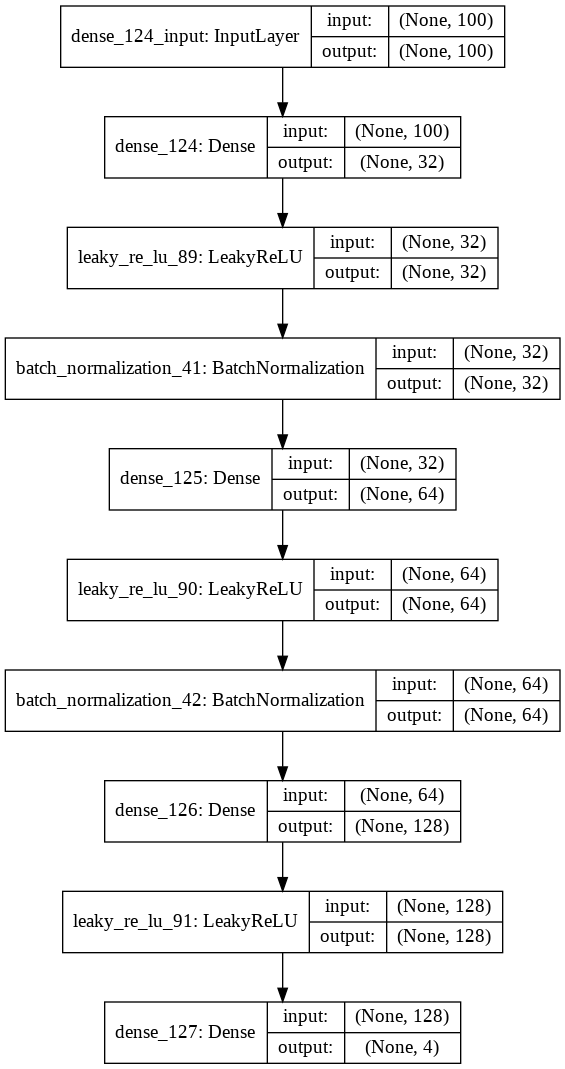

In [175]:
generator = build_generator(numerical_data_rescaled.shape[1], 100)
plot_model(generator, show_layer_names = True, show_shapes = True)

#### Luokittelija
 * Luokittelija saa syötteenä generoidun matriisin sekä alkuperäisen data matriisin
 * Ulostulona luokittelu onko syöte generoitu vai alkuperäinen

In [0]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [0]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

#### Alusta luokittelija ja tulosta mallin rakenne


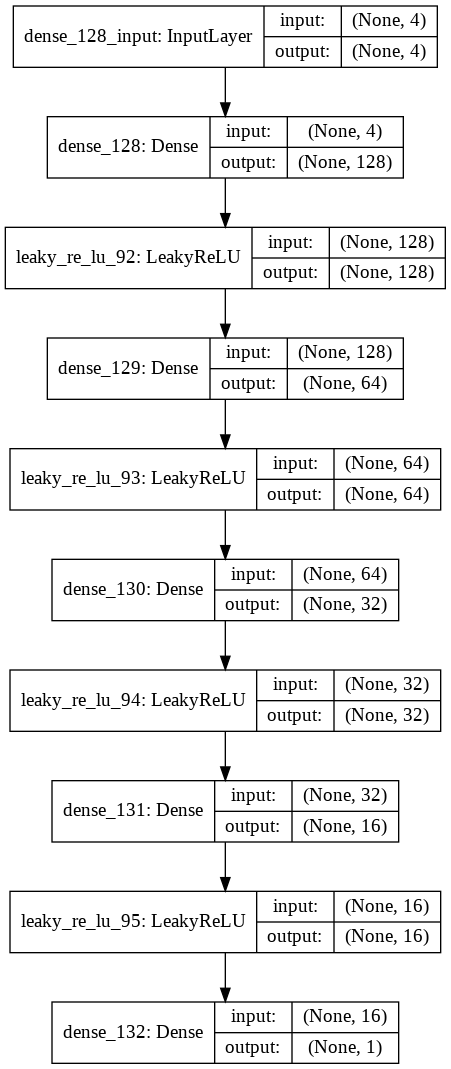

In [178]:
discriminator = build_discriminator(numerical_data_rescaled.shape[1])
plot_model(discriminator, show_layer_names = True, show_shapes = True)

#### Yhdistä generaattori ja luokittelija GAN-verkoksi
 * GAN saa syötteenä generaattorin syötteen
 * Ulostulona luokittelu onko väärennös vai alkuperäinen (luokittelija ulostulo)

In [0]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

#### Alusta GAN ja tulosta verkon rakenne

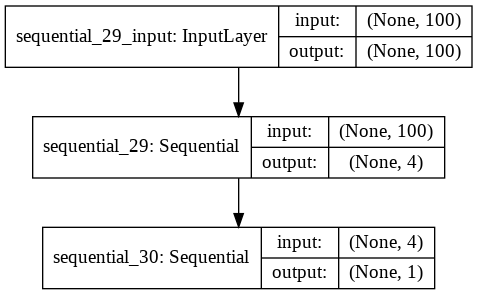

In [180]:
gan = build_gan(generator, discriminator)
plot_model(gan, show_layer_names = True, show_shapes = True)

#### GAN-verkon koulutus

In [0]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()

Epoch: 200 [Generator loss: 0.714883] [Discriminator loss: 0.689205]
Epoch: 400 [Generator loss: 0.727232] [Discriminator loss: 0.691602]
Epoch: 600 [Generator loss: 0.713432] [Discriminator loss: 0.690676]
Epoch: 800 [Generator loss: 0.709371] [Discriminator loss: 0.693343]
Epoch: 1000 [Generator loss: 0.697418] [Discriminator loss: 0.692371]
Epoch: 1200 [Generator loss: 0.706712] [Discriminator loss: 0.693719]
Epoch: 1400 [Generator loss: 0.695383] [Discriminator loss: 0.695877]
Epoch: 1600 [Generator loss: 0.693808] [Discriminator loss: 0.695524]
Epoch: 1800 [Generator loss: 0.695920] [Discriminator loss: 0.695152]
Epoch: 2000 [Generator loss: 0.697148] [Discriminator loss: 0.696346]
Epoch: 2200 [Generator loss: 0.694401] [Discriminator loss: 0.698744]
Epoch: 2400 [Generator loss: 0.698379] [Discriminator loss: 0.695901]
Epoch: 2600 [Generator loss: 0.693223] [Discriminator loss: 0.697952]
Epoch: 2800 [Generator loss: 0.703715] [Discriminator loss: 0.695005]
Epoch: 3000 [Generator l

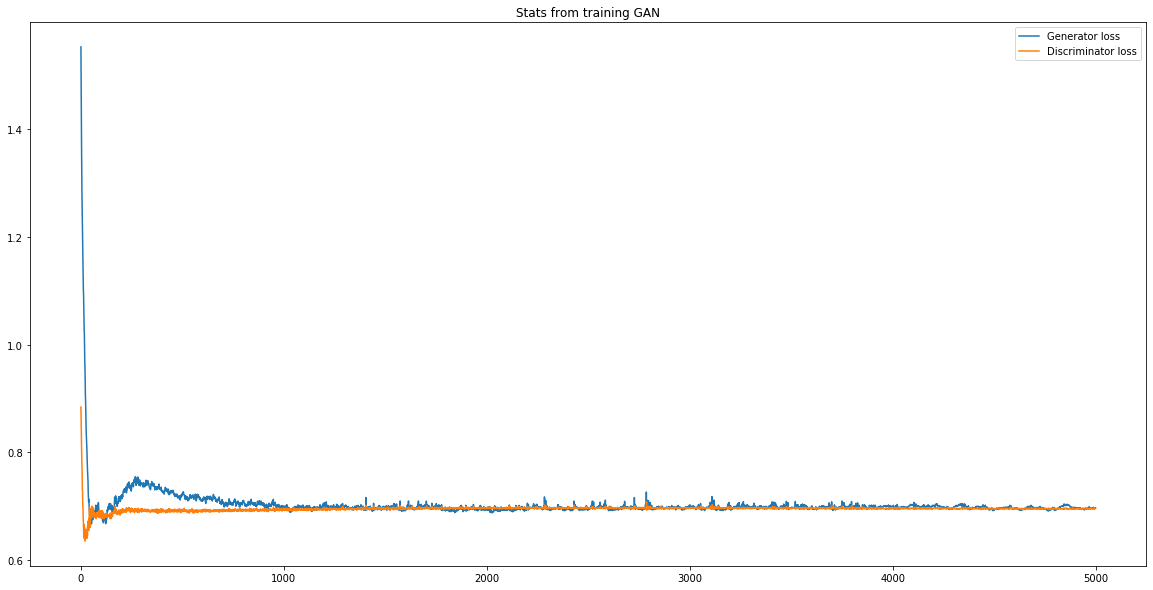

In [182]:
train(gan, generator, discriminator, numerical_data_rescaled, latent_dim = 100, n_epochs = 5000, n_batch = 256, n_eval = 200)

### Numeerisen datan generointi käyttäen generaattori funktiota




In [183]:
noise = np.random.normal(0, 1, (10000, 100))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

array([[0.46804884, 0.37730384, 0.39857805, 0.56150955],
       [0.4533348 , 0.39917707, 0.38694796, 0.51924247],
       [0.05795091, 0.44883788, 0.5146462 , 0.72405505],
       ...,
       [0.9519539 , 0.36577585, 0.51093817, 0.77792203],
       [0.02572131, 0.23590693, 0.30041605, 0.5157419 ],
       [0.9151149 , 0.31943995, 0.25460985, 0.34762073]], dtype=float32)

### Muunnetaan generoitu data alkuperäiseen muotoon

In [184]:
generated_numerical_data = mms.inverse_transform(generated_numerical_data)
gen_df = pd.DataFrame(data = generated_numerical_data, columns = numerical_data.columns)
gen_df

,patient_id,Height,Weight,bmi
0,46798.992188,1.615338,66.462189,25.321337
1,45327.867188,1.629080,65.379219,24.578281
2,5796.990234,1.660282,77.270195,28.178888
3,15017.728516,1.753374,83.177994,26.888132
4,8199.894531,1.659822,63.768505,22.752131
...,...,...,...,...
9995,30541.435547,1.621454,72.407791,27.218403
9996,74507.101562,1.743797,85.760147,28.197540
9997,95180.296875,1.608095,76.924911,29.125870
9998,2574.642334,1.526500,57.321560,24.516741


### Alkuperäisen ja generoidun datan vertailu
 * normaalijakauma
 * keskiarvo, varianssi, keskihajonta
 * korrelaatiomatriisi

In [0]:
def normal_distribution(r, f):

	r_x = np.linspace(r.min(), r.max(), len(r))
	f_x = np.linspace(f.min(), f.max(), len(f))

	r_y = scipy.stats.norm.pdf(r_x, r.mean(), r.std())
	f_y = scipy.stats.norm.pdf(f_x, f.mean(), f.std())
 
	n, bins, patches = plt.hist([r, f], density = True, alpha = 0.5, color = ["black", "red"])
	xmin, xmax = plt.xlim()

	plt.plot(r_x, r_y, color = "black", label = "Original data", alpha = 0.5)
	plt.plot(f_x, f_y, color = "red", label = "Generated data", alpha = 0.5)
	title = f"Original data mean {np.round(r.mean(), 4)}, Original data std {np.round(r.std(), 4)}, Original data var {np.round(r.var(), 4)}\nGenerated data mean {np.round(f.mean(), 4)}, Generated data {np.round(f.std(), 4)}, Generated data var {np.round(f.var(), 2)}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()
 

patient_id Normal distribution


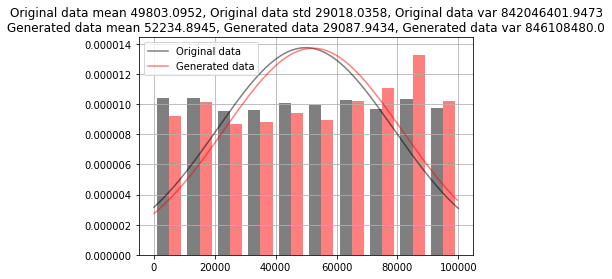

Height Normal distribution


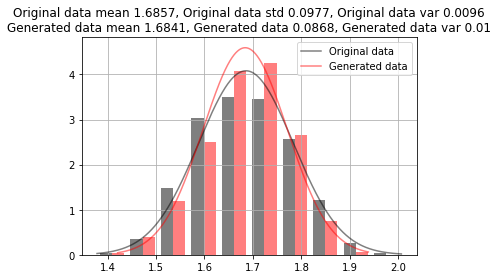

Weight Normal distribution


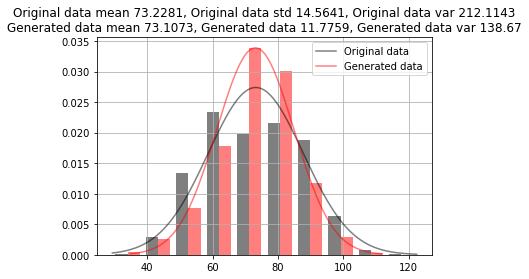

bmi Normal distribution


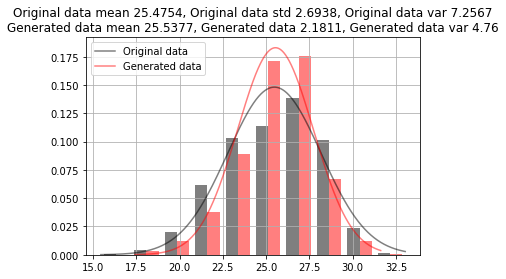

In [186]:
for column in gen_df.columns:
    print(column, "Normal distribution")
    normal_distribution(numerical_data[column], gen_df[column])

Original data


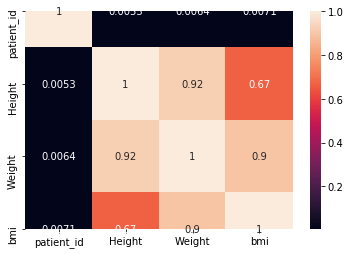

In [187]:
#correlation matrix compareing
print("Original data")
sns.heatmap(numerical_data.corr(), annot = True)

Generated data


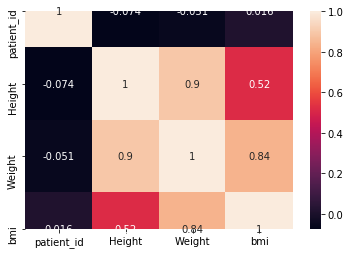

In [188]:
print("Generated data")
sns.heatmap(gen_df.corr(), annot = True)

# *Tulokset*
 * Huomataan, että normaalijakauman, keskiarvo, keskihajonta ja varianssi hyvin samanlainen kuin alkuperäinen
 * Korrelaatio hyvin samanlainen kuin alkuperäinen


--------------------------------------------------------------------------------

# Kategoristen muuttujien generointi GAN-verolla
 * Muutetaan vain generaattorin viimeinen aktivointifuntio softmaxiksi ja luokittelijan syötteen koko ensimmäisestä esimerkistä
 * Testataan hetero- ja homogeenistä data joukkoa

##### Heterogeeninen data

#### Generaattori

In [0]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim = latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(8,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(n_columns, activation = "softmax"))
    return model

In [0]:
generator2 = build_generator(bmi_class_ohe.shape[1], 100)

####Luokittelija

In [0]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [0]:
discriminator2 = build_discriminator(bmi_class_ohe.shape[1])

#### GAN ja kolutus

In [0]:
gan2 = build_gan(generator2, discriminator2)

Epoch: 100 [Generator loss: 1.586192] [Discriminator loss: 0.416356]
Epoch: 200 [Generator loss: 1.265546] [Discriminator loss: 0.530695]
Epoch: 300 [Generator loss: 1.091586] [Discriminator loss: 0.579814]
Epoch: 400 [Generator loss: 0.991897] [Discriminator loss: 0.596093]
Epoch: 500 [Generator loss: 0.938761] [Discriminator loss: 0.622864]
Epoch: 600 [Generator loss: 0.902333] [Discriminator loss: 0.642931]
Epoch: 700 [Generator loss: 0.873942] [Discriminator loss: 0.652404]
Epoch: 800 [Generator loss: 0.853005] [Discriminator loss: 0.666417]
Epoch: 900 [Generator loss: 0.838437] [Discriminator loss: 0.674906]
Epoch: 1000 [Generator loss: 0.832370] [Discriminator loss: 0.669362]
Epoch: 1100 [Generator loss: 0.811865] [Discriminator loss: 0.675757]
Epoch: 1200 [Generator loss: 0.801790] [Discriminator loss: 0.680825]
Epoch: 1300 [Generator loss: 0.803073] [Discriminator loss: 0.678005]
Epoch: 1400 [Generator loss: 0.800212] [Discriminator loss: 0.689297]
Epoch: 1500 [Generator loss: 

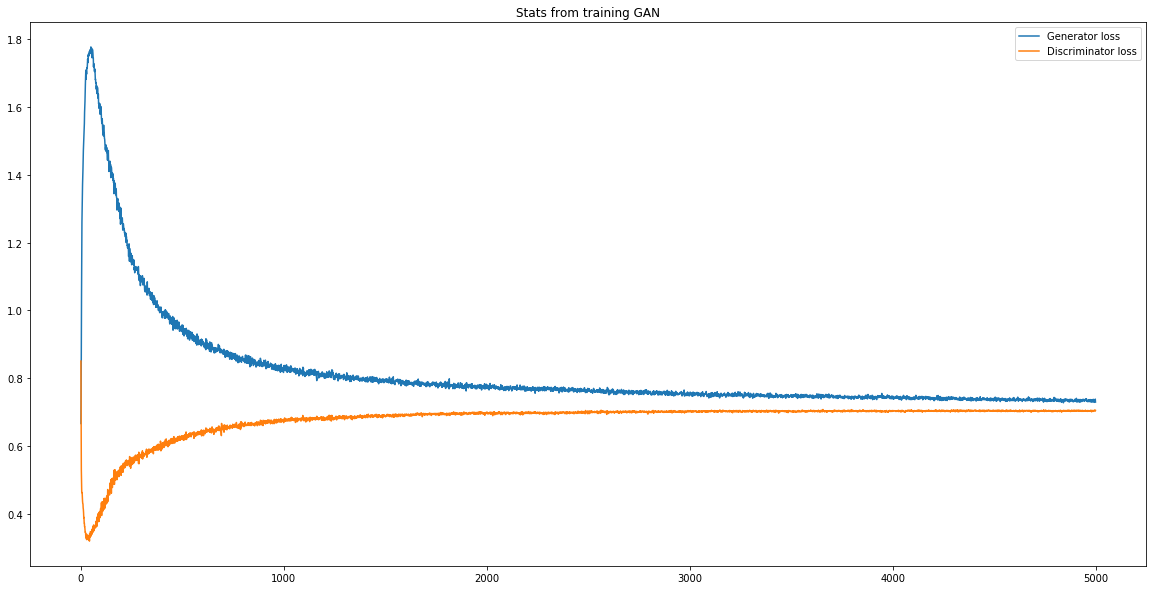

In [194]:
train(gan2, generator2, discriminator2, bmi_class_ohe.values, latent_dim = 100, n_epochs = 5000, n_batch = 10000, n_eval = 100)

### Kategorisen datan generointi käyttäen generaattori funktiota

In [246]:
noise = np.random.normal(0, 1, (10000, 100))
generated_categorical_data = generator2.predict(noise)
generated_categorical_data

array([[1.82423136e-07, 1.99611265e-11, 9.99999285e-01, 4.39748135e-07],
       [3.43220734e-07, 9.99901175e-01, 8.30356294e-05, 1.53753044e-05],
       [3.80162896e-06, 9.99949098e-01, 2.50419380e-05, 2.20392376e-05],
       ...,
       [9.99922633e-01, 4.63223842e-07, 4.89015147e-05, 2.79550422e-05],
       [4.43381026e-07, 9.99978304e-01, 1.27723324e-05, 8.46285002e-06],
       [6.79901423e-05, 9.99786079e-01, 1.00252044e-04, 4.57940150e-05]],
      dtype=float32)

### Pyöristetään generoitu data alkuperäiseen muotoon

In [247]:
gen_df2 = pd.DataFrame(data = np.round(generated_categorical_data), columns = bmi_class_ohe.columns)
gen_df2

,healthy,overweight,severely overweight,underweight
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
9995,0.0,1.0,0.0,0.0
9996,0.0,1.0,0.0,0.0
9997,1.0,0.0,0.0,0.0
9998,0.0,1.0,0.0,0.0


#### Alkuperäisen ja generoidun vertailu
 * lasketaan generoidut ohe muuttujat

In [248]:
#original data
for column in gen_df2.columns:
    print(bmi_class_ohe[column].value_counts())

0    6429
1    3571
Name: healthy, dtype: int64
1    5929
0    4071
Name: overweight, dtype: int64
0    9542
1     458
Name: severely overweight, dtype: int64
0    9958
1      42
Name: underweight, dtype: int64


In [249]:
#generated data
for column in gen_df2.columns:
    print(gen_df2[column].value_counts())

0.0    6174
1.0    3826
Name: healthy, dtype: int64
1.0    5980
0.0    4020
Name: overweight, dtype: int64
0.0    9806
1.0     194
Name: severely overweight, dtype: int64
0.0    10000
Name: underweight, dtype: int64


#### Homogeeninen data



In [0]:
generator3 = build_generator(gender_ohe.shape[1], 100)

In [0]:
discriminator3 = build_discriminator(gender_ohe.shape[1])

In [0]:
gan3 = build_gan(generator3, discriminator3)

Epoch: 50 [Generator loss: 0.849237] [Discriminator loss: 0.662664]
Epoch: 100 [Generator loss: 0.794747] [Discriminator loss: 0.670545]
Epoch: 150 [Generator loss: 0.771406] [Discriminator loss: 0.680476]
Epoch: 200 [Generator loss: 0.756564] [Discriminator loss: 0.686231]
Epoch: 250 [Generator loss: 0.743144] [Discriminator loss: 0.691561]
Epoch: 300 [Generator loss: 0.737690] [Discriminator loss: 0.691362]
Epoch: 350 [Generator loss: 0.730456] [Discriminator loss: 0.692157]
Epoch: 400 [Generator loss: 0.727098] [Discriminator loss: 0.694657]
Epoch: 450 [Generator loss: 0.727020] [Discriminator loss: 0.694604]
Epoch: 500 [Generator loss: 0.725329] [Discriminator loss: 0.694250]
Epoch: 550 [Generator loss: 0.720345] [Discriminator loss: 0.695747]
Epoch: 600 [Generator loss: 0.719885] [Discriminator loss: 0.696870]
Epoch: 650 [Generator loss: 0.718138] [Discriminator loss: 0.696672]
Epoch: 700 [Generator loss: 0.717033] [Discriminator loss: 0.696759]
Epoch: 750 [Generator loss: 0.71502

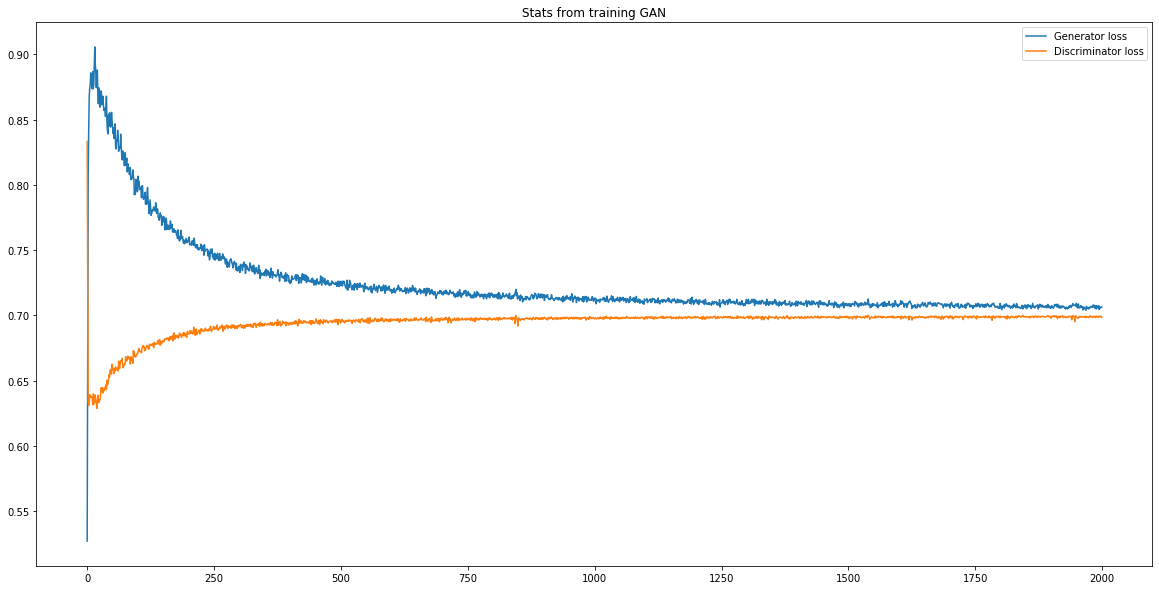

In [202]:
train(gan3, generator3, discriminator3, gender_ohe.values, latent_dim = 100, n_epochs = 2000, n_batch = 10000, n_eval = 50)

### Kategorisen datan generointi käyttäen generaattori funktiota

In [250]:
noise = np.random.normal(0, 1, (10000, 100))
generated_categorical_data2 = generator3.predict(noise)
generated_categorical_data2

array([[9.77708623e-05, 9.99902248e-01],
       [9.99859452e-01, 1.40541873e-04],
       [2.87412782e-04, 9.99712527e-01],
       ...,
       [2.33921433e-08, 1.00000000e+00],
       [9.99993205e-01, 6.77040680e-06],
       [9.99878287e-01, 1.21712495e-04]], dtype=float32)

### Pyöristetään generoitu data alkuperäiseen muotoon

In [251]:
gen_df3 = pd.DataFrame(data = np.round(generated_categorical_data2), columns = gender_ohe.columns)
gen_df3

,Female,Male
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
9995,0.0,1.0
9996,0.0,1.0
9997,0.0,1.0
9998,1.0,0.0


#### Alkuperäisen ja generoidun vertailu
 * lasketaan generoidut ohe muuttujat

In [252]:
#original data value count
for column in gen_df3.columns:
    print(gender_ohe[column].value_counts())

1    5000
0    5000
Name: Female, dtype: int64
1    5000
0    5000
Name: Male, dtype: int64


In [253]:
#generated data value count
for column in gen_df3.columns:
    print(gen_df3[column].value_counts())

0.0    5064
1.0    4936
Name: Female, dtype: int64
1.0    5064
0.0    4936
Name: Male, dtype: int64


# *Tulokset*
 * Heterogeeninen datajoukko, suhteellisen samanlainen, lukuunottamatta pientä määrää alipainoisia (udenrweight) luokkamuuttujia, joita generaattori ei generoinut ollenkaan
 * Homogeeninen datajoukko samanlainen noin 1% virhe generoitujen kategoristen muuttjien lukumäärässä

--------------------------------------------------------------------------------

# Kategoristen ja numeeristen muutujien generointi GAN-verkolla

#### Generaattori
 * Generaattori saa syötteenä satunnaisia arvoja normaalista jakaumasta ja kolumnien määrän, jotta generoitujen kolumnien määrä vastaisi alkuperäistä
 * Generoidut kategoriset ja numeeriset muuttujat yhdistetään yhdeksi matriisiksi, joka syötetään luokittelijalle
 * Käytetään keras funktio apia luomaan monimutkaisempi verkko

In [0]:
def build_generator(categorical_data_shape, categorical_data_shape2, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating categorical gender data
    branch_1_hidden_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1_hidden_1 = LeakyReLU(0.2)(branch_1_hidden_1)
    branch_1_hidden_1 = BatchNormalization(momentum = 0.8)(branch_1_hidden_1)

    branch_1_hidden_2 = Dense(64, kernel_initializer = "he_uniform")(branch_1_hidden_1)
    branch_1_hidden_2 = LeakyReLU(0.2)(branch_1_hidden_2)
    branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
    #Output 1 layer, softmax activation for multi classification
    branch_1_output = Dense(categorical_data_shape, activation = "softmax")(branch_1_hidden_2)

    #Branch 2 for generating categorical bmi_class data
    branch_2_hidden_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2_hidden_1 = LeakyReLU(0.2)(branch_2_hidden_1)
    branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

    branch_2_hidden_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2_hidden_1)
    branch_2_hidden_2 = LeakyReLU(0.2)(branch_2_hidden_2)
    branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
    #Output 2 layer, softmax activation for multi classification
    branch_2_output = Dense(categorical_data_shape2, activation = "softmax")(branch_2_hidden_2)

    #Branch 3 for generating numerical data
    branch_3_hidden_1 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)
    branch_3_hidden_1 = LeakyReLU(0.2)(branch_3_hidden_1)
    branch_3_hidden_1 = BatchNormalization(momentum=0.8)(branch_3_hidden_1)

    branch_3_hidden_2 = Dense(128, kernel_initializer = "he_uniform")(branch_3_hidden_1)
    branch_3_hidden_2 = LeakyReLU(0.2)(branch_3_hidden_2)
    branch_3_hidden_2 = BatchNormalization(momentum=0.8)(branch_3_hidden_2)
    #Output 3, sigmoid activation
    branch_3_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_3_hidden_2)

    #Combined output
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output])
    #Return model
    return Model(inputs = noise, outputs = combined_output)

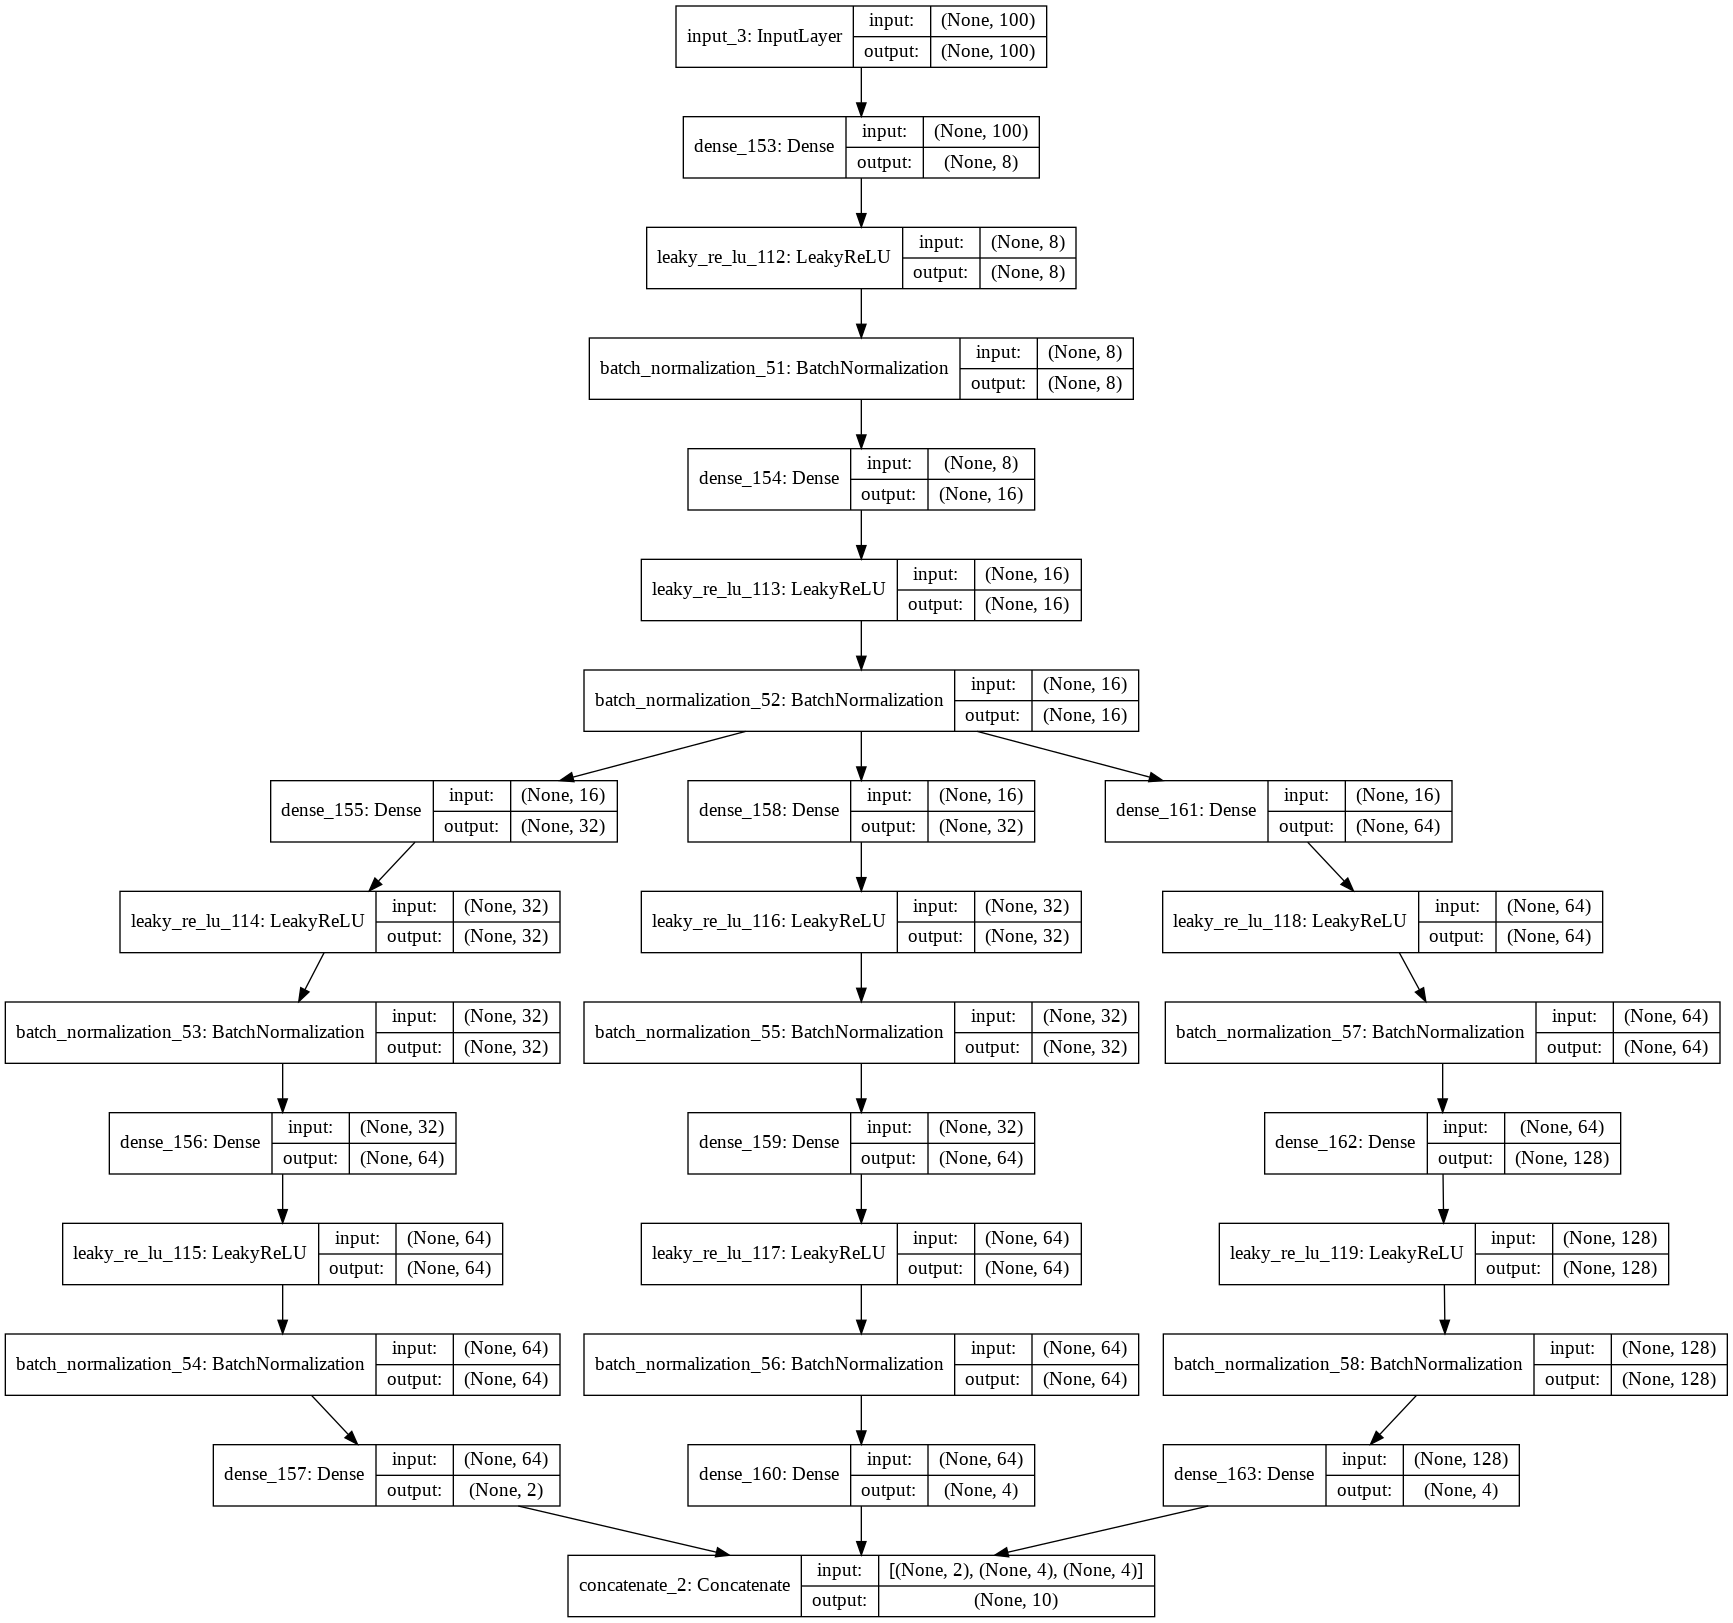

In [208]:
generator4 = build_generator(gender_ohe.shape[1], bmi_class_ohe.shape[1], numerical_data_rescaled.shape[1])
plot_model(generator4, show_layer_names = True, show_shapes = True)

#### Luokittelija
 * Luokittelija saa syötteenä generoidun ja alkuperäisen data matriisin
 * Ulostulona luokittelu onko syöte generoitu vai alkuperäinen

In [0]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [210]:
inputs_n = gender_ohe.shape[1] + bmi_class_ohe.shape[1] + numerical_data_rescaled.shape[1]
inputs_n

10

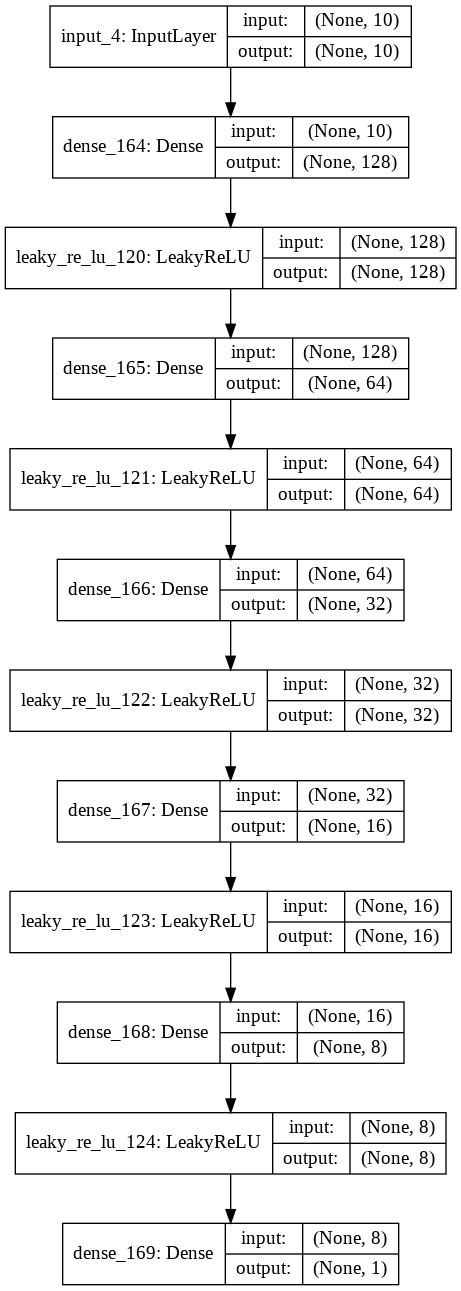

In [211]:
discriminator4 = build_discriminator(inputs_n)
plot_model(discriminator4, show_layer_names = True, show_shapes = True)

#### Yhdistä generaattori ja luokittelija GAN-verkoksi
 * GAN saa syötteenä generaattorin syötteen
 * Ulostulona luokittelu onko väärennös vai alkuperäinen (luokittelija ulostulo)

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

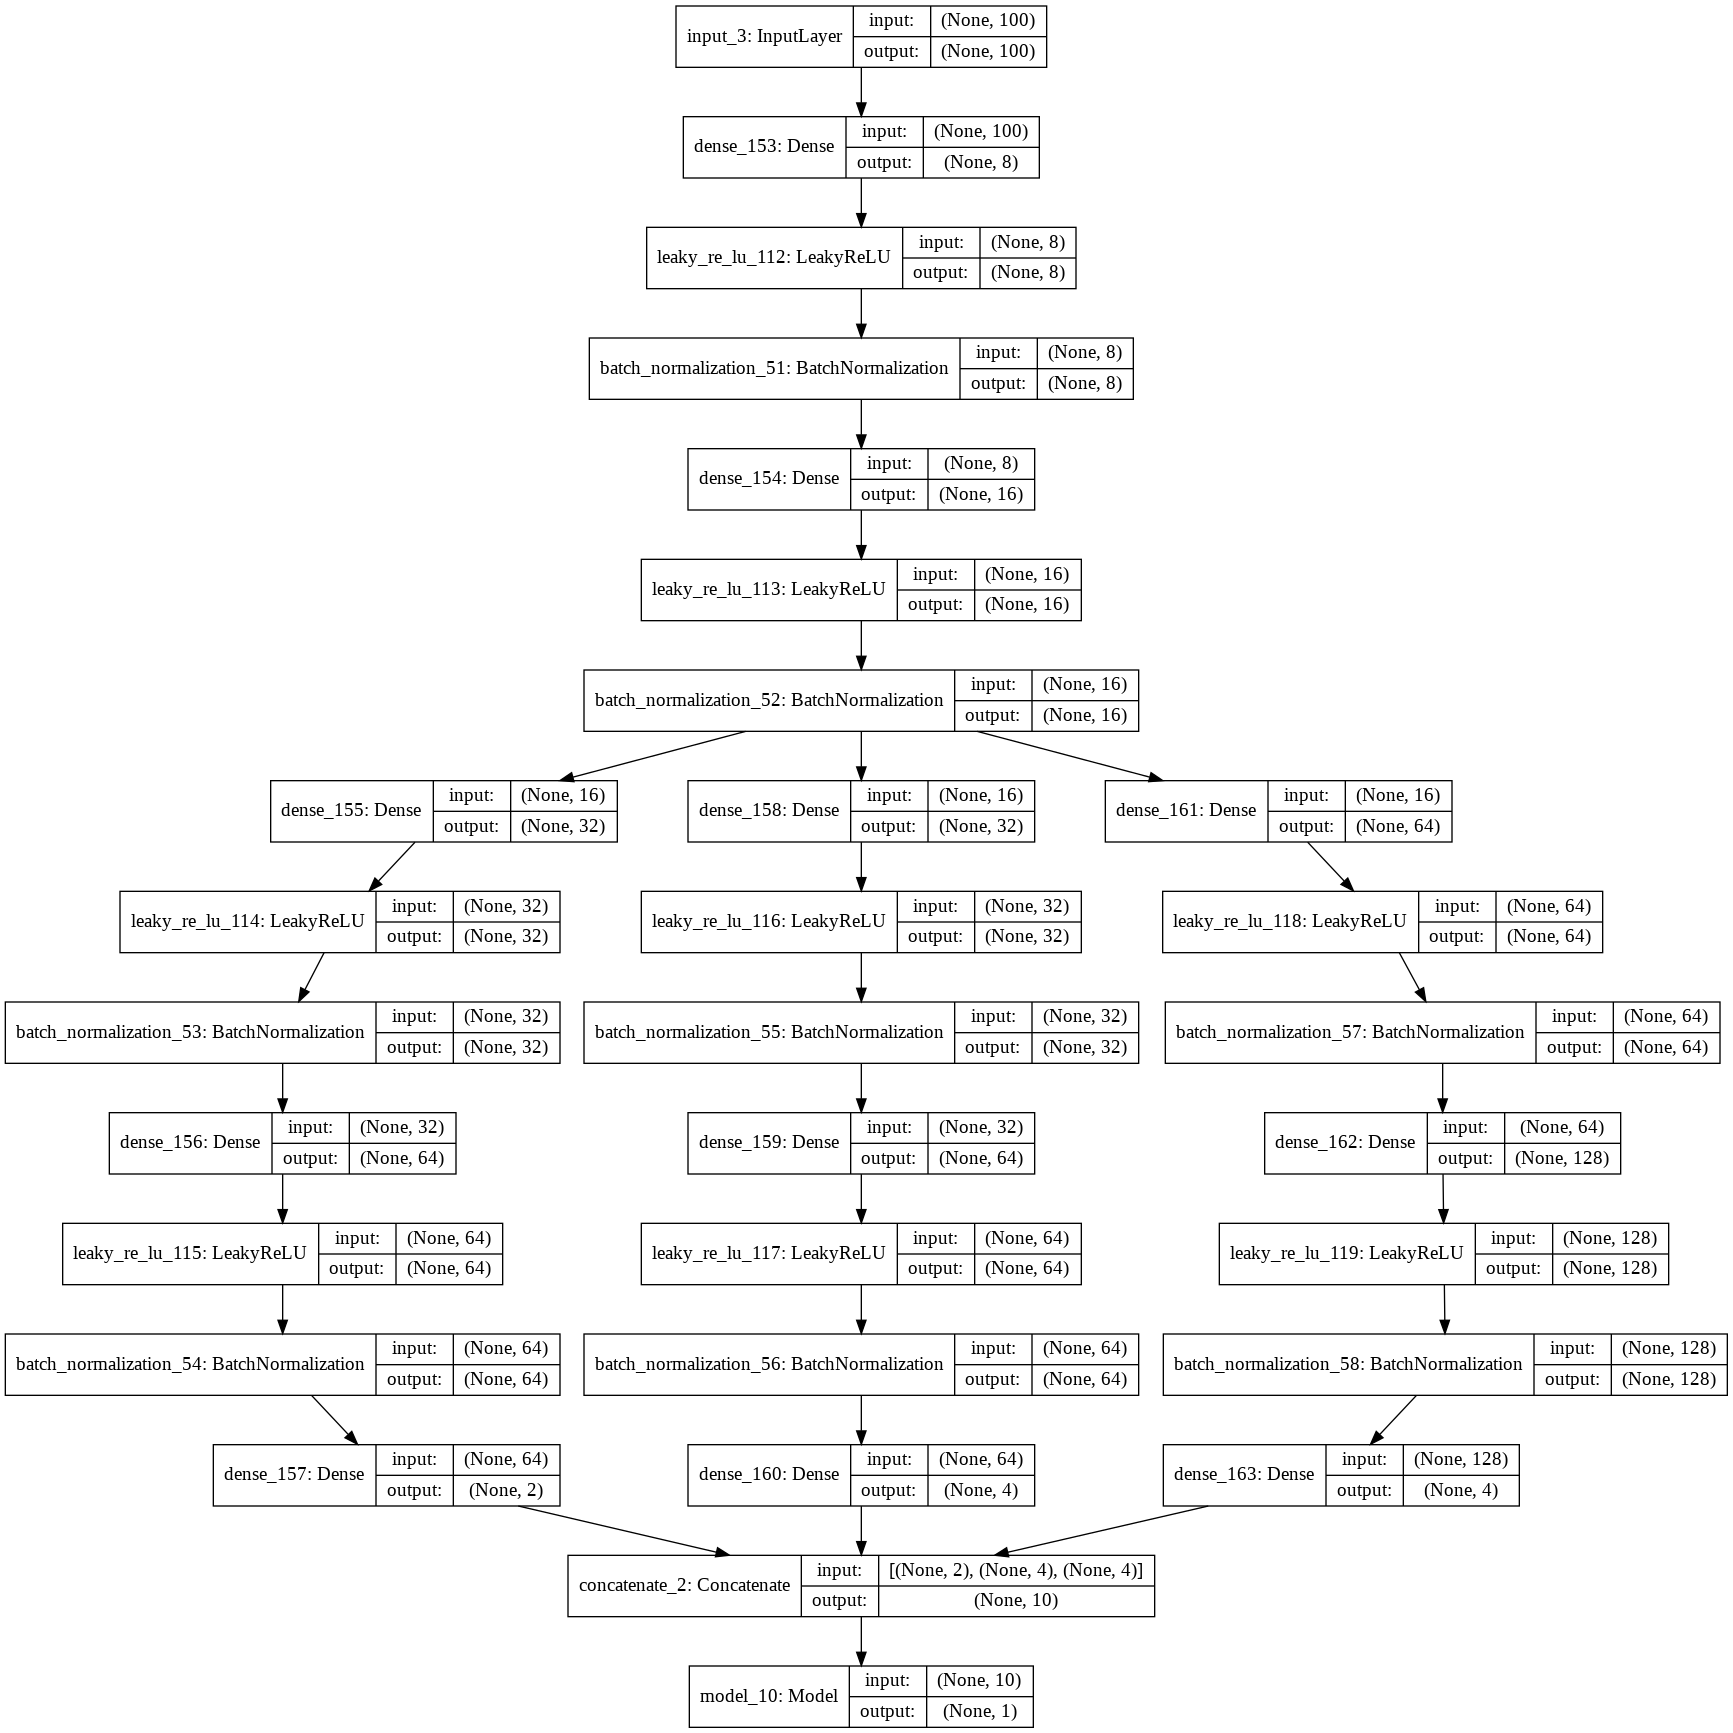

In [213]:
gan4 = build_gan(generator4, discriminator4)
plot_model(gan4, show_layer_names = True, show_shapes = True)

#### GAN koulutus

In [0]:
def train(gan, generator, discriminator, categorical_data, categorical_data2, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)
    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []
    dis_acc_real = []
    dis_acc_fake = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        gender_real = categorical_data[idx]
        bmi_real = categorical_data2[idx]
        numerical_real = numerical_data[idx]
        
        #concatenate categorical and numerical data for discriminator input
        real_data = np.concatenate([gender_real, bmi_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
        dis_acc_real.append(d_loss_real)
        dis_acc_fake.append(d_loss_fake)
        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.plot(dis_acc_real, label = "Discriminator accuracy real")
    plt.plot(dis_acc_fake, label = "Discriminator accuracy fake")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

Epoch: 250 [Discriminator loss: 0.681143] [Generator loss: 0.725108]
Epoch: 500 [Discriminator loss: 0.681293] [Generator loss: 0.719871]
Epoch: 750 [Discriminator loss: 0.682567] [Generator loss: 0.729842]
Epoch: 1000 [Discriminator loss: 0.683711] [Generator loss: 0.718464]
Epoch: 1250 [Discriminator loss: 0.688206] [Generator loss: 0.718916]
Epoch: 1500 [Discriminator loss: 0.685180] [Generator loss: 0.721528]
Epoch: 1750 [Discriminator loss: 0.685969] [Generator loss: 0.720010]
Epoch: 2000 [Discriminator loss: 0.691701] [Generator loss: 0.714128]
Epoch: 2250 [Discriminator loss: 0.687194] [Generator loss: 0.719203]
Epoch: 2500 [Discriminator loss: 0.686917] [Generator loss: 0.729754]
Epoch: 2750 [Discriminator loss: 0.687813] [Generator loss: 0.731301]
Epoch: 3000 [Discriminator loss: 0.684322] [Generator loss: 0.720492]
Epoch: 3250 [Discriminator loss: 0.687753] [Generator loss: 0.727689]
Epoch: 3500 [Discriminator loss: 0.688724] [Generator loss: 0.719034]
Epoch: 3750 [Discrimina

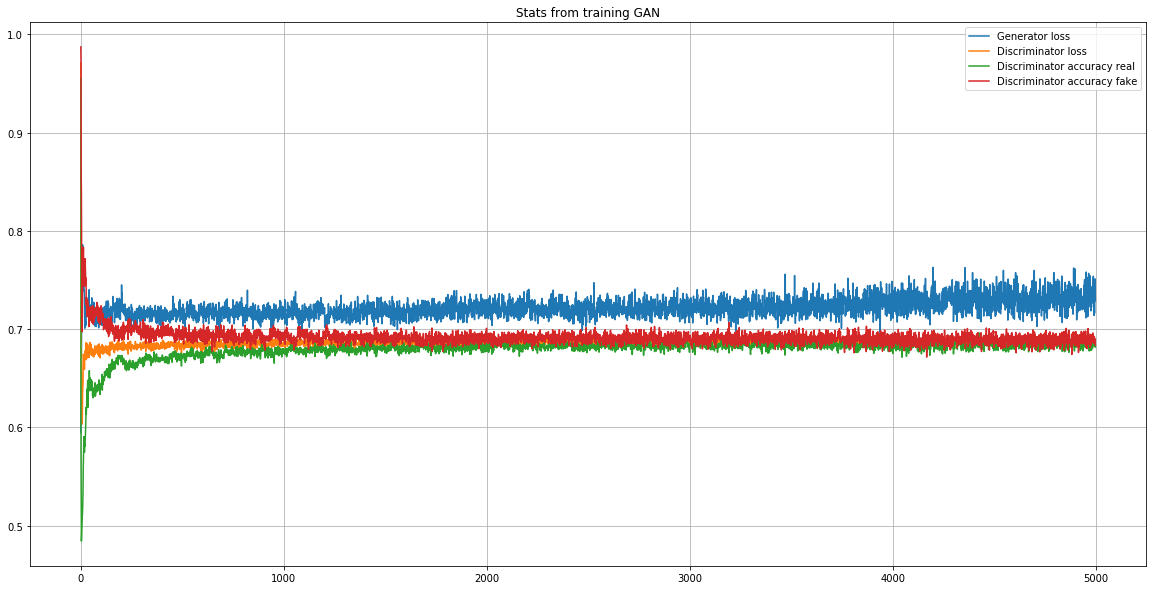

In [215]:
train(gan4, generator4, discriminator4, gender_ohe.values, bmi_class_ohe.values, numerical_data_rescaled, latent_dim = 100, n_epochs = 5000, n_batch = 1024, n_eval = 250)

### Kategorisen ja numeerisen datan generointi käyttäen generaattori funktiota

In [216]:
noise = np.random.normal(0, 1, (10000, 100))
generated_mixed_data = generator4.predict(noise)
generated_mixed_data

array([[2.1699423e-22, 1.0000000e+00, 9.0609072e-28, ..., 5.2324057e-01,
        5.4718328e-01, 6.9568169e-01],
       [0.0000000e+00, 1.0000000e+00, 1.1945124e-23, ..., 5.3041881e-01,
        5.3195292e-01, 6.5824425e-01],
       [1.1426177e-34, 1.0000000e+00, 3.0777132e-24, ..., 4.9941045e-01,
        4.6980196e-01, 5.5590987e-01],
       ...,
       [1.9381285e-33, 1.0000000e+00, 6.3810971e-23, ..., 7.7186549e-01,
        7.1318609e-01, 6.7216706e-01],
       [3.6562815e-25, 1.0000000e+00, 2.8898771e-16, ..., 5.1071459e-01,
        4.9320498e-01, 5.8202726e-01],
       [0.0000000e+00, 1.0000000e+00, 5.3469157e-18, ..., 4.8461881e-01,
        4.7111374e-01, 5.7818872e-01]], dtype=float32)

### Muunnetaan generoitu data alkuperäiseen muotoon

In [217]:
columns = list(gender_ohe.columns) + list(bmi_class_ohe.columns) + list(numerical_data.columns)
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df

,Female,Male,healthy,overweight,severely overweight,underweight,patient_id,Height,Weight,bmi
0,2.169942e-22,1.000000e+00,9.060907e-28,1.000000e+00,1.399785e-16,7.472536e-15,0.391915,0.523241,0.547183,0.695682
1,0.000000e+00,1.000000e+00,1.194512e-23,1.000000e+00,4.207920e-14,3.176294e-13,0.900566,0.530419,0.531953,0.658244
2,1.142618e-34,1.000000e+00,3.077713e-24,1.000000e+00,9.867002e-15,1.067670e-12,0.279325,0.499410,0.469802,0.555910
3,4.545423e-25,1.000000e+00,5.989664e-15,2.749563e-27,1.000000e+00,8.026944e-11,0.266263,0.620275,0.701610,0.862301
4,1.076919e-30,1.000000e+00,1.094947e-23,1.000000e+00,1.229965e-15,1.832937e-14,0.098891,0.689789,0.688771,0.755700
...,...,...,...,...,...,...,...,...,...,...
9995,0.000000e+00,1.000000e+00,3.251181e-26,1.000000e+00,1.093360e-13,2.802349e-12,0.957873,0.751698,0.745320,0.769100
9996,1.000000e+00,7.142956e-28,1.000000e+00,0.000000e+00,1.858610e-27,7.697758e-28,0.204599,0.227191,0.243762,0.425217
9997,1.938128e-33,1.000000e+00,6.381097e-23,1.000000e+00,1.566945e-14,6.425635e-13,0.211781,0.771865,0.713186,0.672167
9998,3.656282e-25,1.000000e+00,2.889877e-16,9.999999e-01,2.409490e-08,1.605306e-07,0.501832,0.510715,0.493205,0.582027


In [218]:
mixed_gen_df.iloc[:, 0:6] = np.round(mixed_gen_df.iloc[:, 0:6])
mixed_gen_df.iloc[:, 6:10] = mms.inverse_transform(mixed_gen_df.iloc[:, 6:10])
mixed_gen_df

,Female,Male,healthy,overweight,severely overweight,underweight,patient_id,Height,Weight,bmi
0,0.0,1.0,0.0,1.0,0.0,0.0,39187.027344,1.707028,80.299980,27.680084
1,0.0,1.0,0.0,1.0,0.0,0.0,90042.507812,1.711537,78.881760,27.021935
2,0.0,1.0,0.0,1.0,0.0,0.0,27930.158203,1.692055,73.094398,25.222895
3,0.0,1.0,0.0,0.0,1.0,0.0,26624.236328,1.767992,94.679810,30.609245
4,0.0,1.0,0.0,1.0,0.0,0.0,9890.270508,1.811667,93.484344,28.735199
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,0.0,1.0,0.0,0.0,95772.109375,1.850564,98.750061,28.970779
9996,1.0,0.0,1.0,0.0,0.0,0.0,20459.035156,1.521024,52.046021,22.925318
9997,0.0,1.0,0.0,1.0,0.0,0.0,21177.123047,1.863235,95.757790,27.266697
9998,0.0,1.0,0.0,1.0,0.0,0.0,50176.691406,1.699158,75.273636,25.682039


In [219]:
#original data
og_data = pd.concat([gender_ohe, bmi_class_ohe, numerical_data], axis = 1)
og_data

,Female,Male,healthy,overweight,severely overweight,underweight,patient_id,Height,Weight,bmi
0,0,1,0,0,1,0,90329,1.875714,109.721075,31.19
1,0,1,1,0,0,0,82793,1.747060,73.622792,24.12
2,0,1,0,1,0,0,98691,1.882397,96.497629,27.23
3,0,1,0,0,1,0,20430,1.821967,99.809586,30.07
4,0,1,0,0,1,0,96554,1.774998,93.598695,29.71
...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,0,0,0,51506,1.680785,62.041210,21.96
9996,1,0,0,1,0,0,38900,1.703506,77.504378,26.71
9997,1,0,1,0,0,0,26718,1.622247,58.275424,22.14
9998,1,0,1,0,0,0,67447,1.753470,74.322226,24.17


### Alkuperäisen ja generoidun datan vertailu
 * normaalijakauma, keskiarvo, varianssi, keskihajonta
 * korrelaatiomatriisi
 * kategoristen muuttujien laskeminen
 * neuroverkko luokittelija

normaalijakauma, keskiarvo, varianssi, keskihajonta

Female Normal distribution


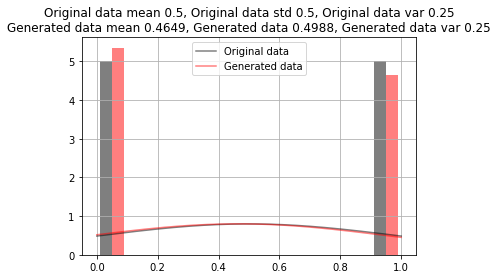

Male Normal distribution


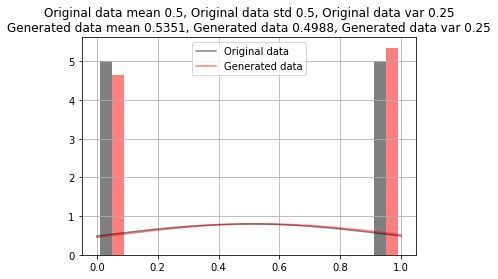

healthy Normal distribution


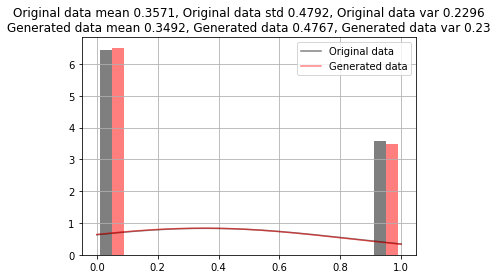

overweight Normal distribution


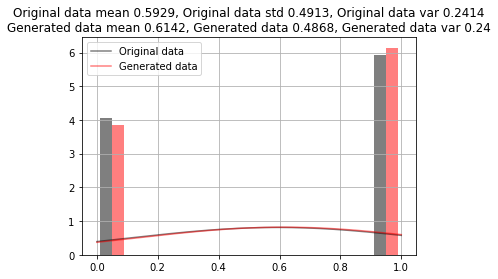

severely overweight Normal distribution


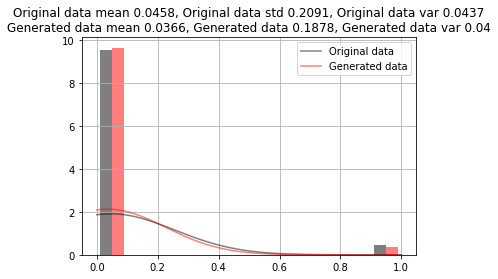

underweight Normal distribution


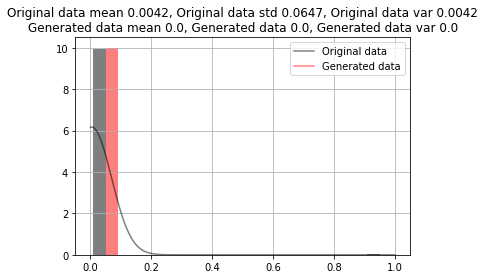

patient_id Normal distribution


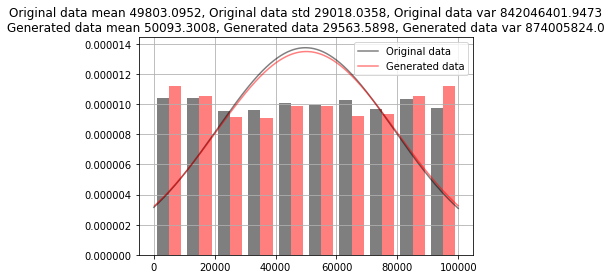

Height Normal distribution


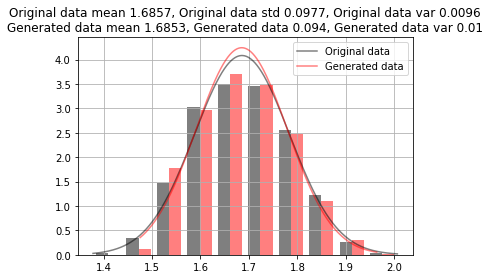

Weight Normal distribution


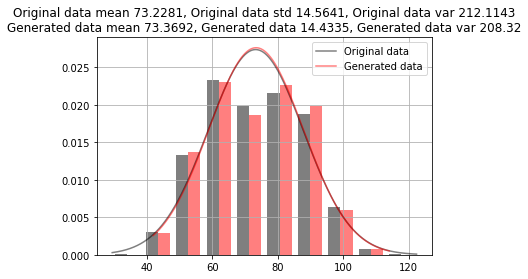

bmi Normal distribution


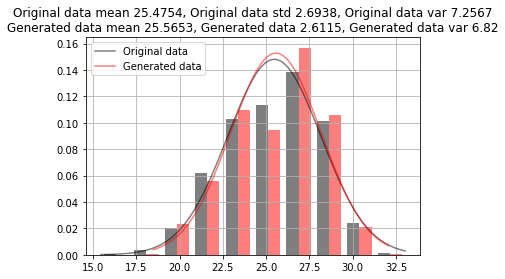

In [276]:
for column in mixed_gen_df.columns:
    print(column, "Normal distribution")
    normal_distribution(og_data[column], mixed_gen_df[column])

korrelaatiomatriisi

Original data


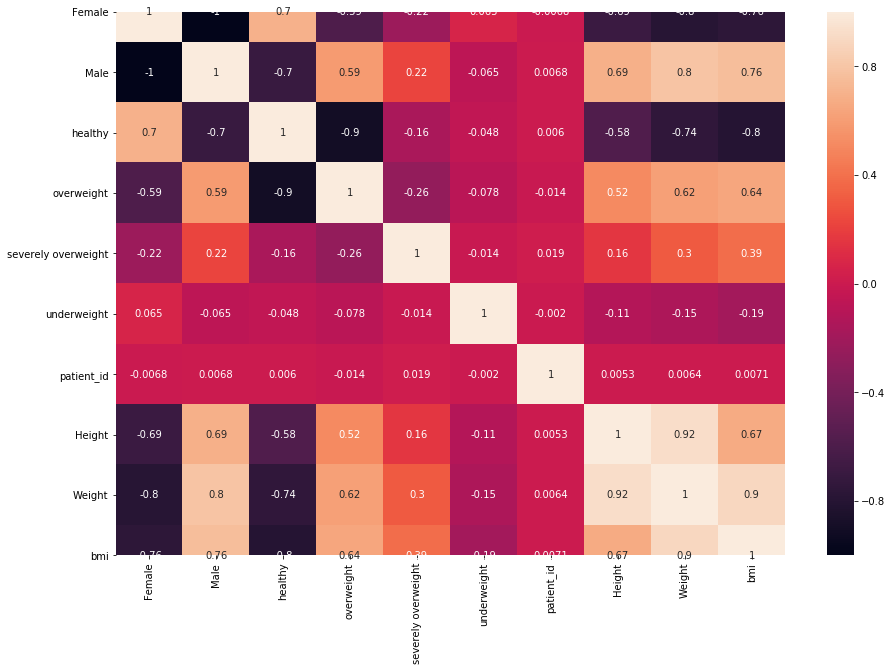

In [221]:
#correlation matrix compareing
print("Original data")
plt.figure(figsize = (15, 10))
sns.heatmap(og_data.corr(), annot = True)

Generated data


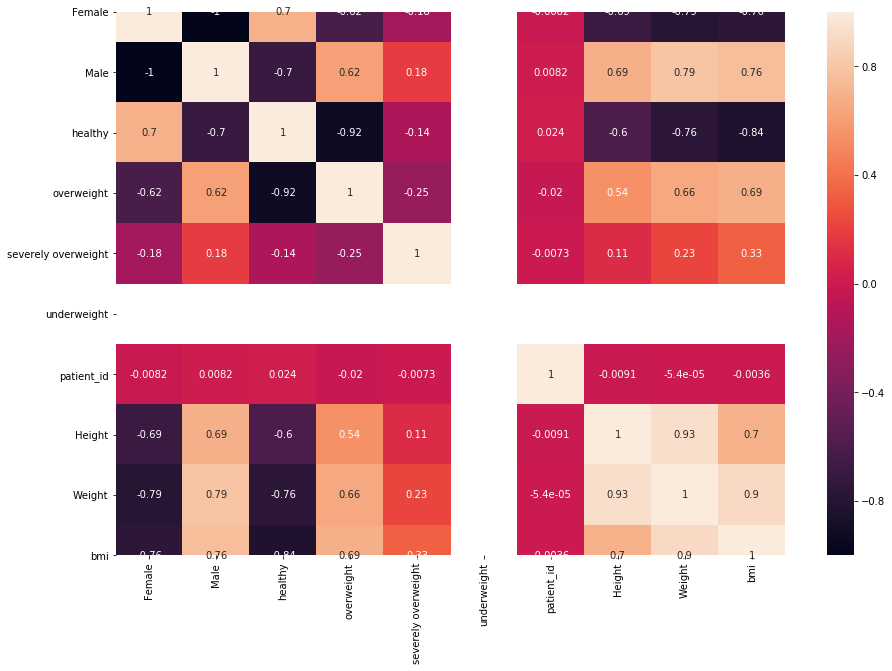

In [222]:
print("Generated data")
plt.figure(figsize = (15, 10))
sns.heatmap(mixed_gen_df.corr(), annot = True)

kategoristen muuttujien laskeminen

In [223]:
for column in og_data.iloc[:, 0:6].columns:
    print(og_data[column].value_counts())

1    5000
0    5000
Name: Female, dtype: int64
1    5000
0    5000
Name: Male, dtype: int64
0    6429
1    3571
Name: healthy, dtype: int64
1    5929
0    4071
Name: overweight, dtype: int64
0    9542
1     458
Name: severely overweight, dtype: int64
0    9958
1      42
Name: underweight, dtype: int64


In [224]:
for column in og_data.iloc[:, 0:6].columns:
    print(mixed_gen_df[column].value_counts())

0.0    5351
1.0    4649
Name: Female, dtype: int64
1.0    5351
0.0    4649
Name: Male, dtype: int64
0.0    6508
1.0    3492
Name: healthy, dtype: int64
1.0    6142
0.0    3858
Name: overweight, dtype: int64
0.0    9634
1.0     366
Name: severely overweight, dtype: int64
0.0    10000
Name: underweight, dtype: int64


neuroverkko luokittelija alkuperöisellä ja generoidulla datalla
 * luokitellaan sukupuolen mukaan

In [0]:
def classifier():
    model = Sequential()
    model.add(Dense(128, activation = "relu", input_dim = 3))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

def classifier_train(classifier, x_train, y_train, epoch_limit=100, batch_size=256):
        
    history = classifier.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_limit, verbose=0)

def evaluate(classifier, x_test, y_test):
    score = classifier.evaluate(x_test, y_test, verbose=1)
    print("Test Loss = {}, Test Accuracy = {}".format(score[0], score[1]))

alkuperäinen data

In [0]:
from sklearn.model_selection import train_test_split

X = og_data.iloc[:, 7:] #features
y = gender_labels #target labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [227]:
model = classifier()
classifier_train(model, x_train, y_train)
evaluate(model, x_test, y_test)

1000/1000 [==============================] - 3s 3ms/step
Test Loss = 0.23355082643032074, Test Accuracy = 0.895


generoitu data

In [228]:
# generated data target labels
gen_dummies = mixed_gen_df.iloc[:, :2]
s = pd.DataFrame(gen_dummies.columns[np.where(gen_dummies != 0)[1]], columns = ["Gender"])
s

,Gender
0,Male
1,Male
2,Male
3,Male
4,Male
...,...
9995,Male
9996,Female
9997,Male
9998,Male


In [229]:
y = le.fit_transform(s)
y

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
X = mixed_gen_df.iloc[:, 7:] #features
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [231]:
model = classifier()
classifier_train(model, x_train, y_train)
evaluate(model, x_test, y_test)

1000/1000 [==============================] - 3s 3ms/step
Test Loss = 0.27845907551050186, Test Accuracy = 0.897


# *Tulokset*
### Kategoriset muuttujat
 * Heterogeeninen datajoukko, suhteellisen samanlainen, lukuunottamatta pientä määrää (0,5 promillea datajoukosta) underweight luokkamuuttujia, joita generaattori ei generoi ollenkaan
 * Homogeeninen datajoukko samanlainen alkuperäiseen nähden noin muutaman prosentin virhe generoitujen kategoristen muuttujien lukumäärässä

### Numeeriset muuttujat
 * Huomataan, että normaalijakauman, keskiarvo, keskihajonta ja varianssi hyvin samanlainen kuin alkuperäinen
 * Korrelaatio hyvin samanlainen kuin alkuperäinen

### Neuroverkko luokittelija
 * Keskiarvollisesti generoidulla datalla yhtä hyvä tarkkuus luokittelussa kuin alkuperäisellä datalla

--------------------------------------------------------------------------------

# Kategorisen ja numeerisen datan generointi käyttäen luokkamuuttujaa (ACGAN)
 * Generaattori saa syötteenä satunnaisia arvoja normaalijakaumasta ja luokkamuuttujan, jonka avulla voidaan generoidu halutun luokan arvoja
 * Luokittelija luokittelee data datajoukon aitouden ja mihin luokkaan data kuuluu

#### Generaattori
 * Saa syötteenä satunnaisia arvoja normaalijakaumasta ja luokkamuuttujan, jonka avulla voidaan generoidu halutun luokan arvoja
 * Käytetään Keras funktio apia luomaan useampi syöte generaattorille

In [0]:
def build_generator(categorical_data_shape, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    noise_branch = Dense(4, kernel_initializer = "he_uniform")(noise)
    noise_branch = LeakyReLU(0.2)(noise_branch)
    noise_branch = Dense(8, kernel_initializer = "he_uniform")(noise_branch)
    noise_branch = LeakyReLU(0.2)(noise_branch)
    #class label input
    label_input = Input(shape = (1,))
    label_branch = Dense(4, kernel_initializer = "he_uniform")(label_input)
    label_branch = LeakyReLU(0.2)(label_branch)
    label_branch = Dense(8, kernel_initializer = "he_uniform")(label_branch)
    label_branch = LeakyReLU(0.2)(label_branch)
    #combine input branches
    merge = concatenate([noise_branch, label_branch])

    hidden_1 = Dense(8, kernel_initializer= "he_uniform")(merge)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum=0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer= "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum=0.8)(hidden_2)


    #Branch 1 for generating categorical data
    branch_1_hidden_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1_hidden_1 = LeakyReLU(0.2)(branch_1_hidden_1)
    branch_1_hidden_1 = BatchNormalization(momentum=0.8)(branch_1_hidden_1)

    branch_1_hidden_2 = Dense(16, kernel_initializer = "he_uniform")(branch_1_hidden_1)
    branch_1_hidden_2 = LeakyReLU(0.2)(branch_1_hidden_2)
    branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
    #Output 1 layer, softmax activation for multi classification. Number of classes
    branch_1_output = Dense(categorical_data_shape, activation = "softmax")(branch_1_hidden_2)

    #Branch 2 for generating numerical data
    branch_2_hidden_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2_hidden_1 = LeakyReLU(0.2)(branch_2_hidden_1)
    branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

    branch_2_hidden_2 = Dense(16, kernel_initializer = "he_uniform")(branch_2_hidden_1)
    branch_2_hidden_2 = LeakyReLU(0.2)(branch_2_hidden_2)
    branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
    #Output 2, sigmoid activation
    branch_2_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_2_hidden_2)

    #Combined output for discriminator
    combined_output = concatenate([branch_1_output, branch_2_output])
    #Return model
    return Model(inputs = [noise, label_input], outputs = combined_output)

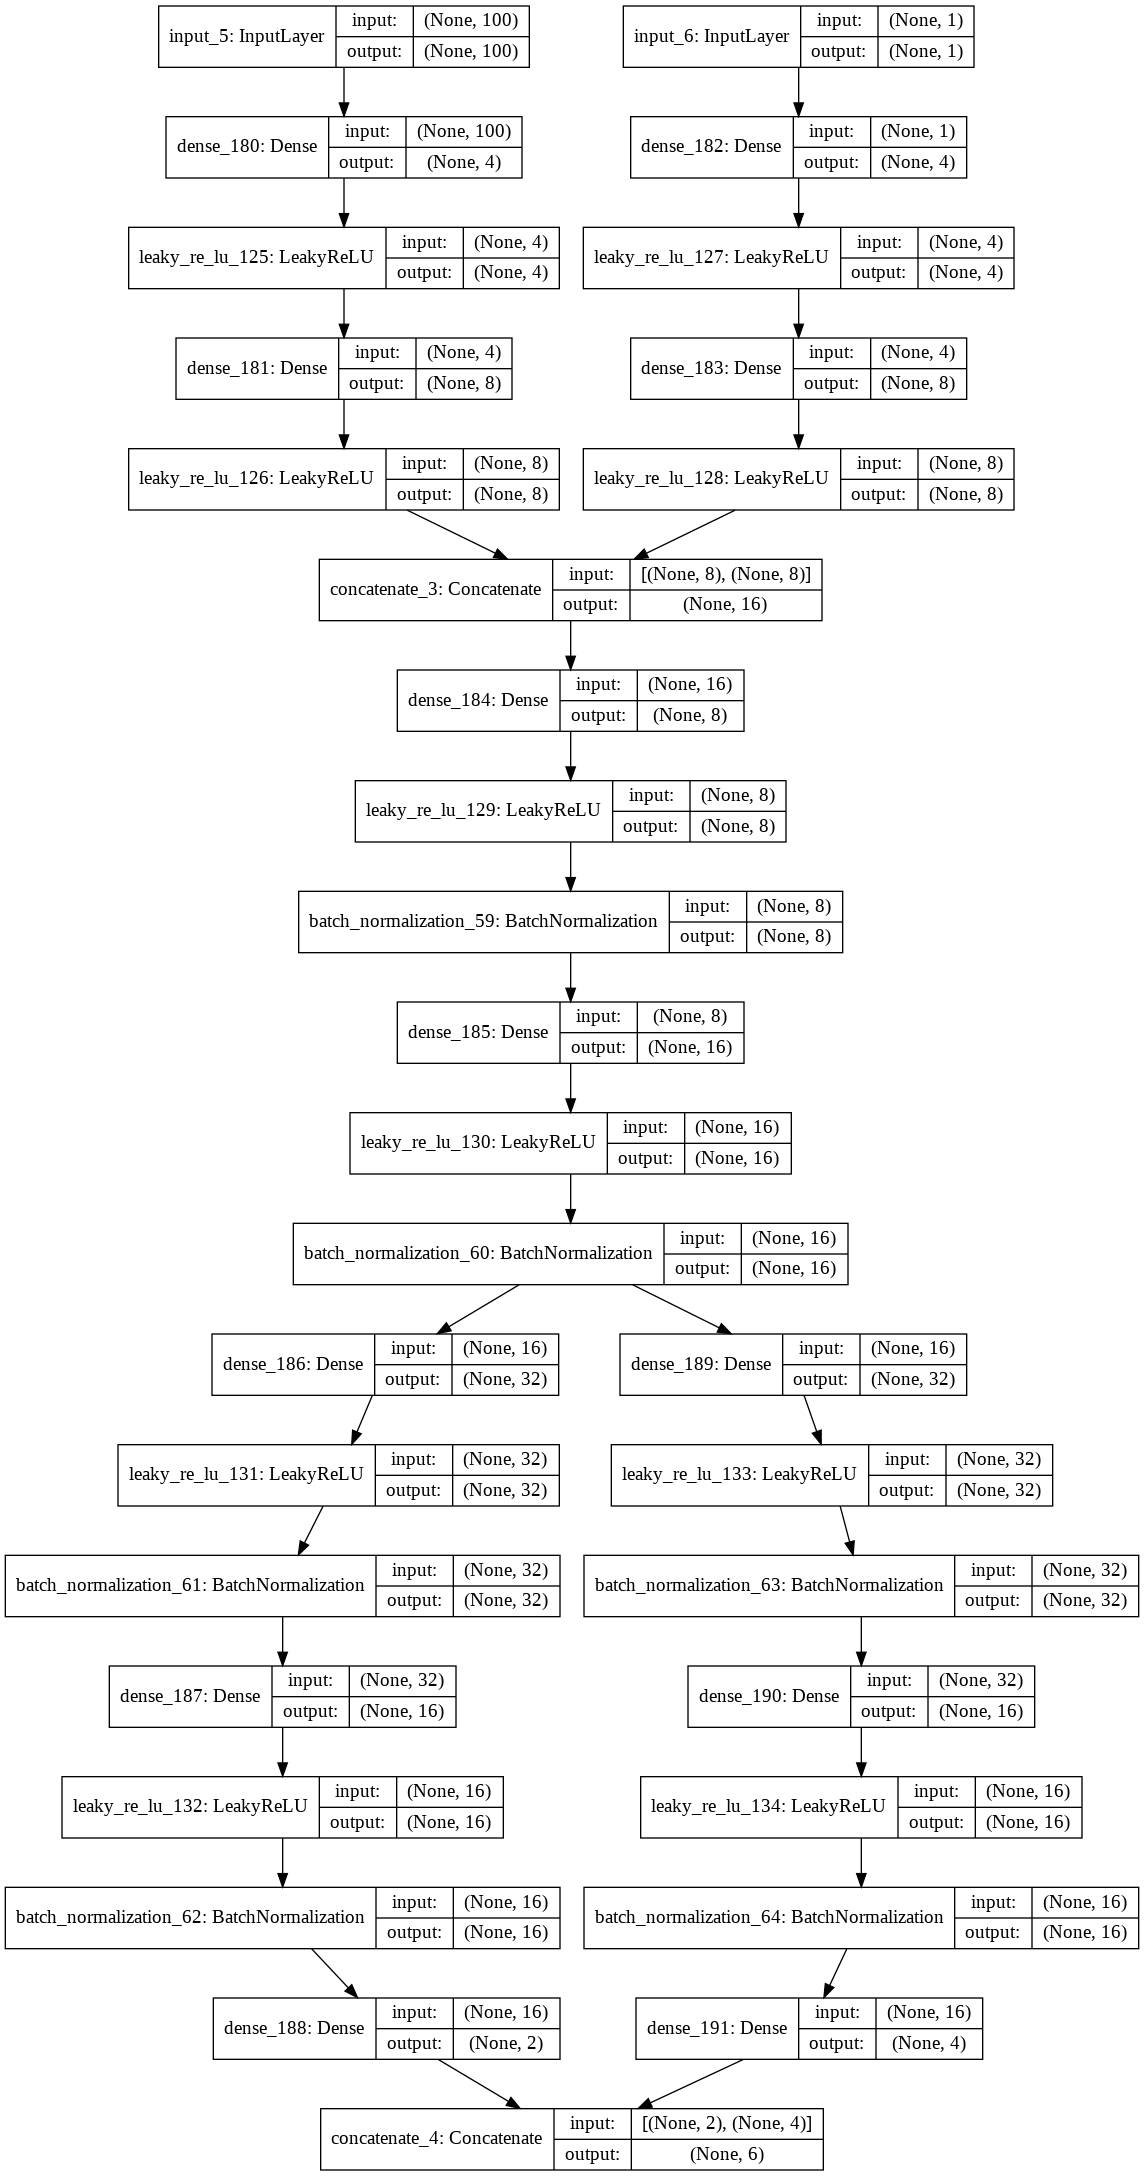

In [233]:
generator5 = build_generator(gender_ohe.shape[1], numerical_data_rescaled.shape[1])
plot_model(generator5, show_layer_names = True, show_shapes = True)

#### Luokittelija
 * Syötteenä kolumnien määrä ja luokkamäärä
 * Ulostulona onko alkuperäinen vai generoitu ja mihin luokkaan kuuluu

In [0]:
def build_discriminator(inputs_n, n_classes):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(32, kernel_initializer = "he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.2)(d)
    d = BatchNormalization(momentum = 0.8)(d)
    d = Dense(64, kernel_initializer = "he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.2)(d)
    d = BatchNormalization(momentum = 0.8)(d)
    d = Dense(32, kernel_initializer = "he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.2)(d)
    d = BatchNormalization(momentum = 0.8)(d)
    d = Dense(16, kernel_initializer = "he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.2)(d)
    d = BatchNormalization(momentum = 0.8)(d)
    d = Dense(8, kernel_initializer = "he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification real or fake and prediction witch class
    output1 = Dense(1, activation = "sigmoid")(d)
    output2 = Dense(n_classes, activation = "softmax")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = [output1, output2])
    model.compile(loss = ["binary_crossentropy", "sparse_categorical_crossentropy"], optimizer = "adam", metrics = ["accuracy"])
    return model

In [0]:
inputs_n = gender_ohe.shape[1] + numerical_data_rescaled.shape[1]

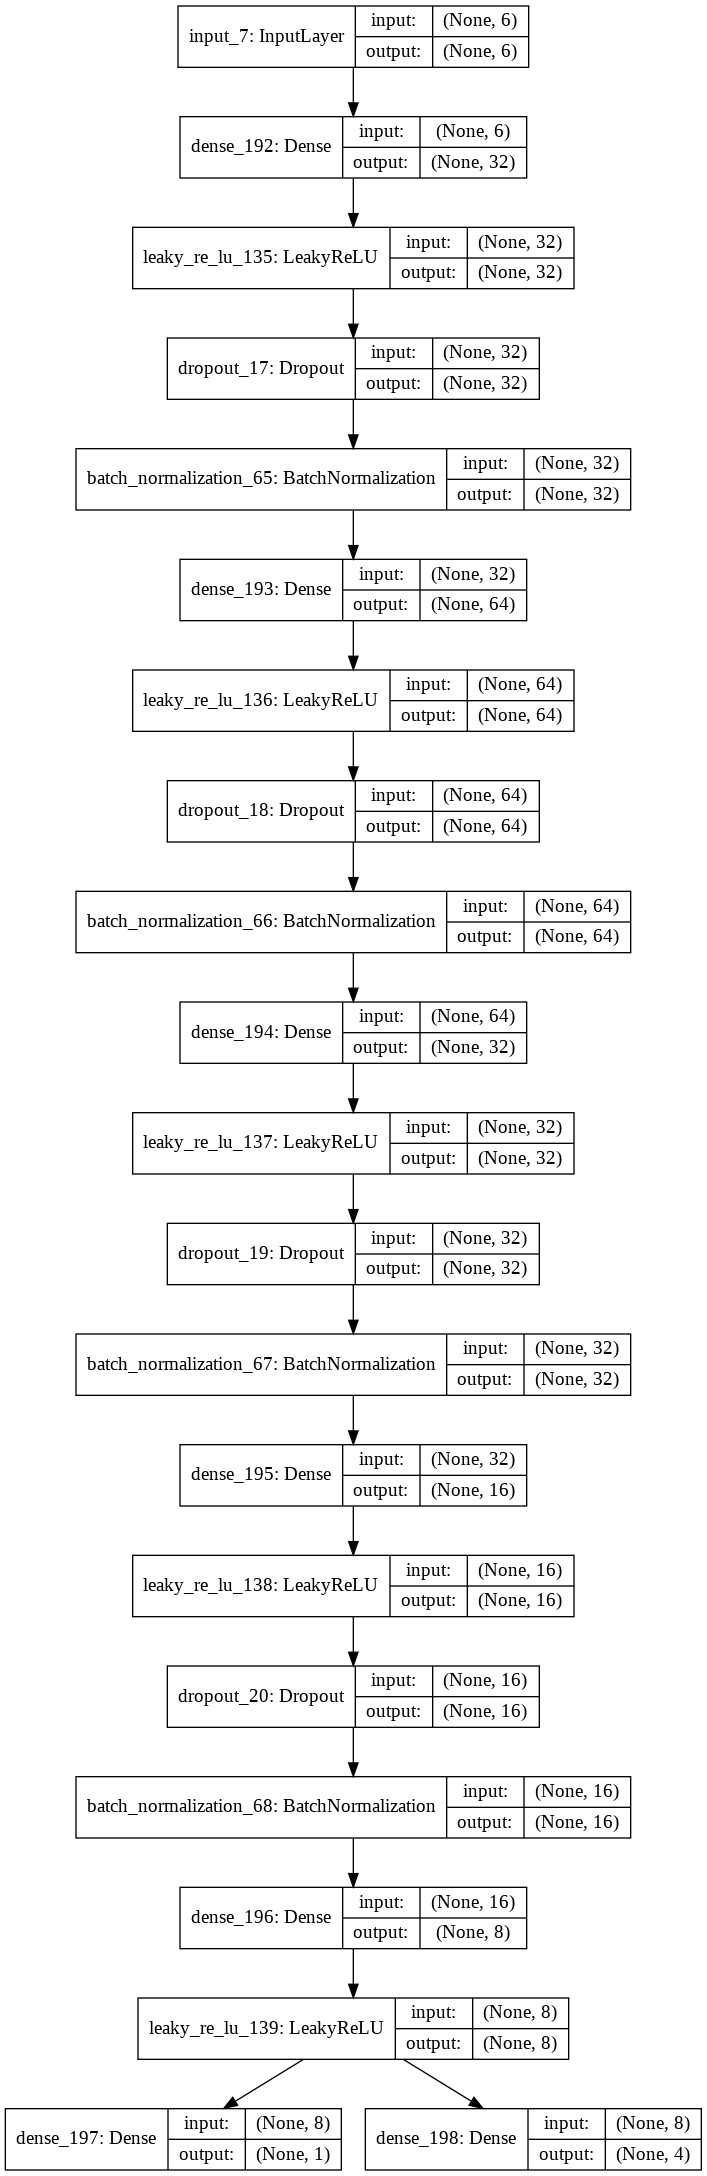

In [236]:
discriminator5 = build_discriminator(inputs_n, bmi_class_ohe.shape[1])
plot_model(discriminator5, show_layer_names = True, show_shapes = True)

#### GAN
 * Syötteenä satunnaismuuttujia normaalijakaumasta ja luokkamuuttujat
 * Ulostulona luokittelu onko generoitu vai alkuperäinen ja luokka ennuste

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss=["binary_crossentropy", "sparse_categorical_crossentropy"], optimizer = optimizer)
    #Return Model
    return model

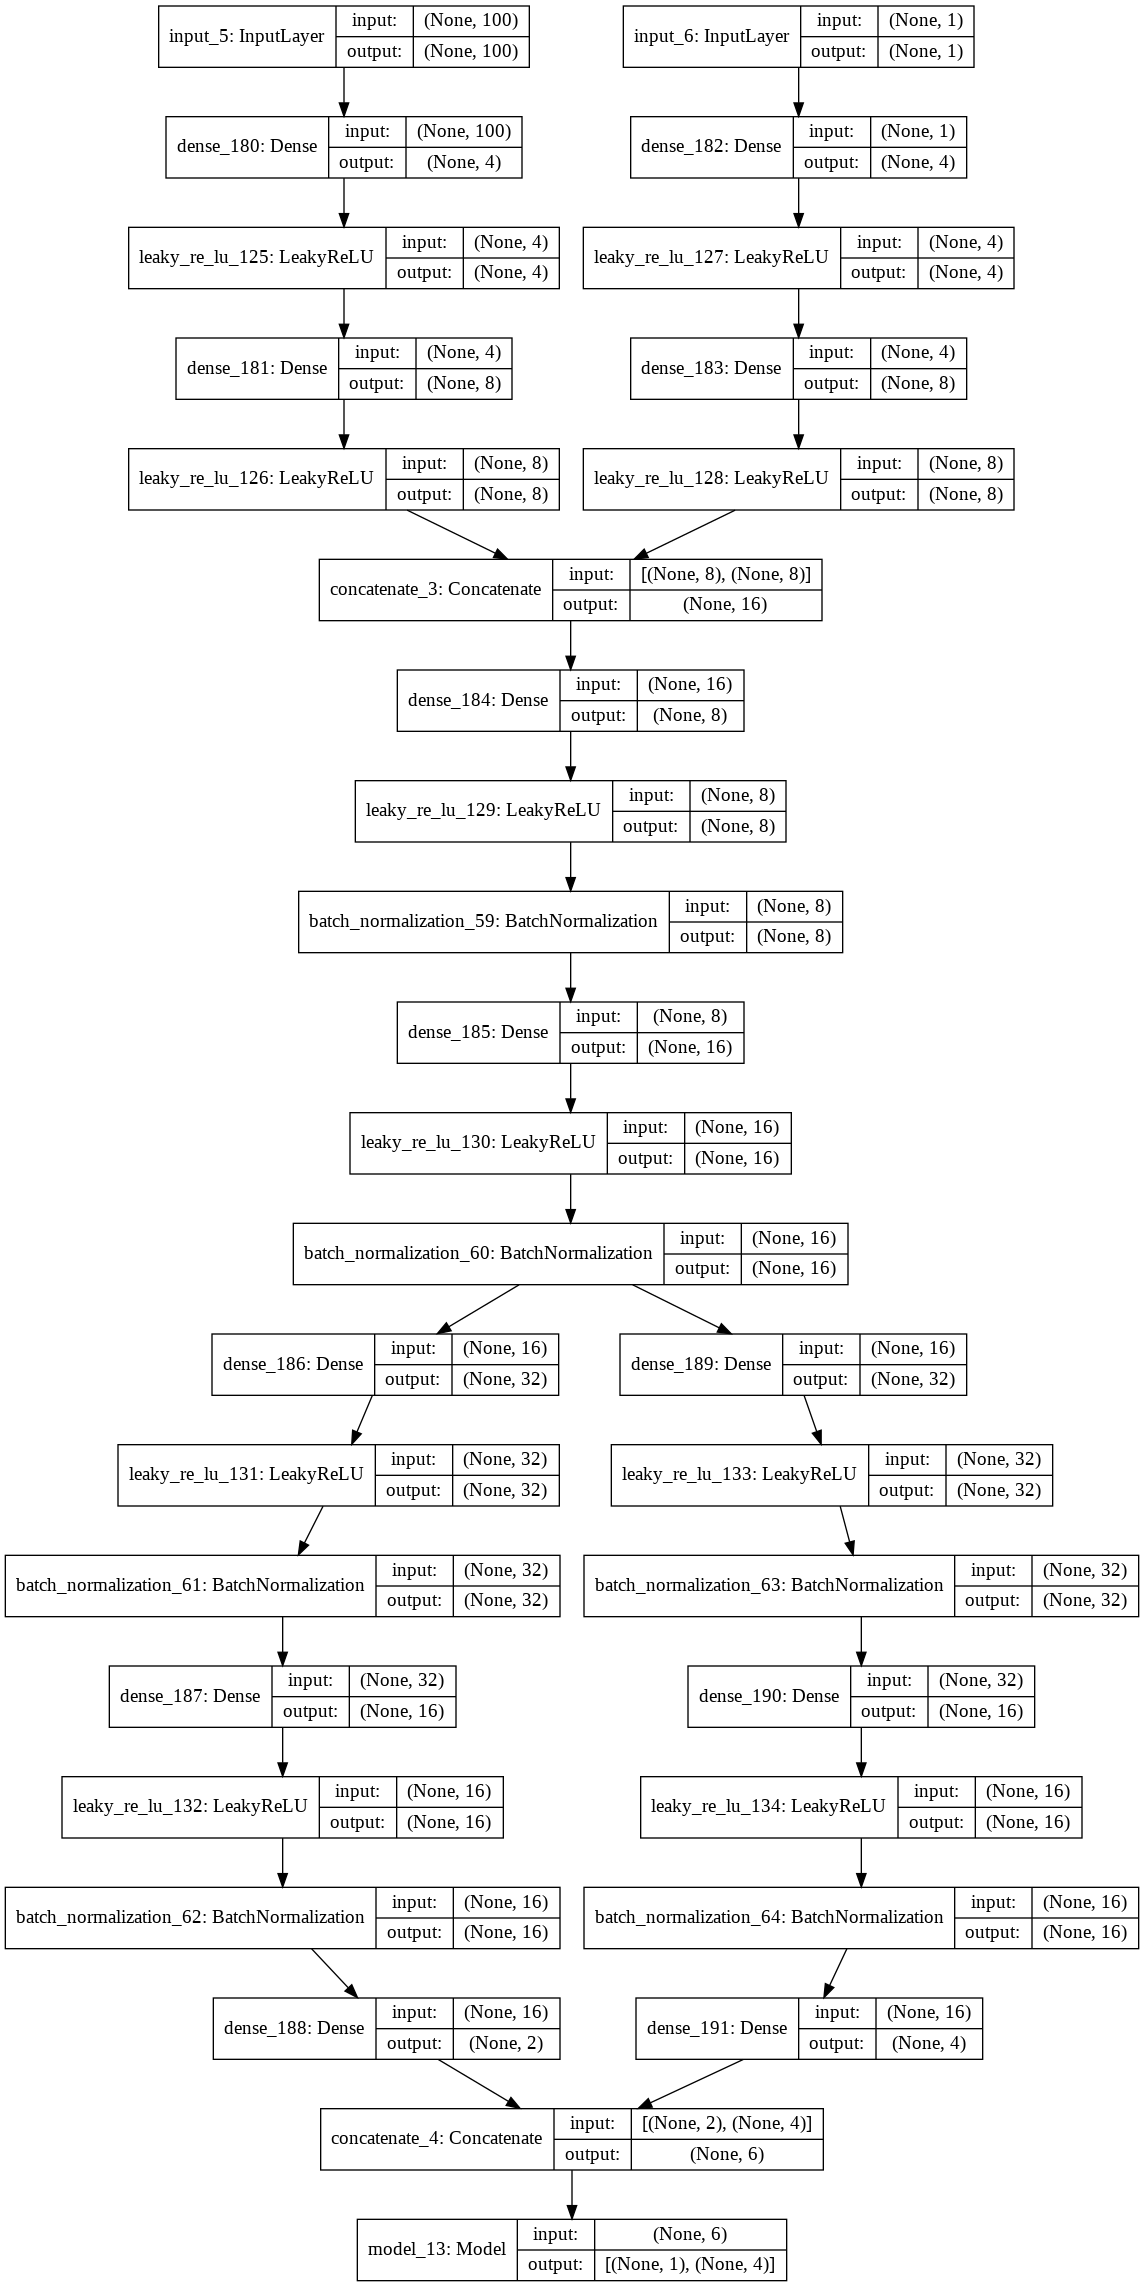

In [238]:
gan5 = build_gan(generator5, discriminator5)
plot_model(gan5, show_layer_names = True, show_shapes = True)

### ACGAN koulutus

In [0]:
def train(gan, generator, discriminator, categorical_data, numerical_data, labels, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)
    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []
    dis_acc_real = []
    dis_acc_fake = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real categorical and numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        categorical_real = categorical_data[idx]
        numerical_real = numerical_data[idx]
        real_labels = labels[idx]
        
        #concatenate categorical and numerical data for discriminator input
        real_data = np.concatenate([categorical_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise and fake labels
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_labels = np.random.randint(0, 4, (half_batch, 1))
        fake_data = generator.predict([noise, fake_labels])

        #train the discriminator and return losses and acc
        d_loss_real = discriminator.train_on_batch(real_data, [valid, real_labels])
        d_loss_fake = discriminator.train_on_batch(fake_data, [fake, fake_labels])

        #append stats from training
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss[0])
        #dis_acc_real.append(d_loss_real)
        #dis_acc_fake.append(d_loss_fake)


        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        noise_labels = np.random.randint(0, 4, (n_batch, 1))
        g_loss, g_1, g_2 = gan.train_on_batch([noise, noise_labels], [y_gan, noise_labels])
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            #print('>%d, dr[%.3f,%f], df[%.3f,%f], g[%.3f,%f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss[0], g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    #plt.plot(dis_acc_real, label = "Discriminator accuracy real")
    #plt.plot(dis_acc_fake, label = "Discriminator accuracy fake")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

In [0]:
train(gan5, generator5, discriminator5, gender_ohe.values, numerical_data_rescaled, gender_labels, latent_dim = 100, n_epochs = 2000, n_batch = 5000, n_eval = 100)

Epoch: 100 [Discriminator loss: 0.627071] [Generator loss: 1.396866]
Epoch: 200 [Discriminator loss: 0.524161] [Generator loss: 1.495955]


### Genereoidaan uutta dataa generaattorilla painoindeksiluokan perusteella




In [0]:
def generate_data(class_num, num_samples):
    noise = np.random.normal(0, 1, (num_samples, 100))
    labels = np.asarray([class_num for _ in range(num_samples)])
    generated_data = generator5.predict([noise ,labels])
    return generated_data

In [268]:
list(le.classes_)

['Female', 'Male']

In [269]:
for column in bmi_class_ohe.columns:
    print(bmi_class_ohe[column].value_counts())

0    6429
1    3571
Name: healthy, dtype: int64
1    5929
0    4071
Name: overweight, dtype: int64
0    9542
1     458
Name: severely overweight, dtype: int64
0    9958
1      42
Name: underweight, dtype: int64


In [0]:
healthy_data = generate_data(0, 3571)
overweight_data = generate_data(1, 5929)
s_overweight_data = generate_data(2, 458)
underweight_data = generate_data(3, 42)

In [0]:
bmi_data = np.concatenate([healthy_data, overweight_data, s_overweight_data, underweight_data], axis = 0)

### Muunnetaan generoitu data alkuperäiseen muotoon

In [272]:
bmi_data = pd.DataFrame(data = bmi_data, columns = list(gender_ohe.columns) + list(numerical_data.columns))
bmi_data

,Female,Male,patient_id,Height,Weight,bmi
0,0.894374,0.105626,0.533337,0.377483,0.382886,0.418947
1,0.900419,0.099581,0.489621,0.317008,0.334619,0.402304
2,0.907090,0.092910,0.393379,0.314399,0.345128,0.380998
3,0.855316,0.144684,0.378943,0.267669,0.293105,0.318687
4,0.911876,0.088124,0.516948,0.337183,0.364633,0.429390
...,...,...,...,...,...,...
9995,0.888672,0.111328,0.382101,0.453955,0.379353,0.352917
9996,0.908409,0.091591,0.369158,0.434416,0.384692,0.383263
9997,0.905353,0.094647,0.379152,0.422317,0.370656,0.383425
9998,0.833621,0.166379,0.135480,0.354562,0.230902,0.460109


In [273]:
bmi_data.iloc[:, :2] = np.round(bmi_data.iloc[:, :2])
bmi_data

,Female,Male,patient_id,Height,Weight,bmi
0,1.0,0.0,0.533337,0.377483,0.382886,0.418947
1,1.0,0.0,0.489621,0.317008,0.334619,0.402304
2,1.0,0.0,0.393379,0.314399,0.345128,0.380998
3,1.0,0.0,0.378943,0.267669,0.293105,0.318687
4,1.0,0.0,0.516948,0.337183,0.364633,0.429390
...,...,...,...,...,...,...
9995,1.0,0.0,0.382101,0.453955,0.379353,0.352917
9996,1.0,0.0,0.369158,0.434416,0.384692,0.383263
9997,1.0,0.0,0.379152,0.422317,0.370656,0.383425
9998,1.0,0.0,0.135480,0.354562,0.230902,0.460109


In [274]:
bmi_data.iloc[:, 2:] = mms.inverse_transform(bmi_data.iloc[:, 2:])
bmi_data

,Female,Male,patient_id,Height,Weight,bmi
0,1.0,0.0,53326.535156,1.615450,65.000984,22.815088
1,1.0,0.0,48955.781250,1.577455,60.506447,22.522503
2,1.0,0.0,39333.433594,1.575815,61.485065,22.147947
3,1.0,0.0,37890.097656,1.546456,56.640774,21.052519
4,1.0,0.0,51687.929688,1.590130,63.301334,22.998676
...,...,...,...,...,...,...
9995,1.0,0.0,38205.796875,1.663496,64.672035,21.654276
9996,1.0,0.0,36911.781250,1.651221,65.169128,22.187763
9997,1.0,0.0,37911.039062,1.643619,63.862194,22.190607
9998,1.0,0.0,13548.379883,1.601049,50.848530,23.538719


### Alkuperäisen ja generoidun datan vertailu
 * normaalijakauma, keskiarvo, varianssi, keskihajonta
 * korrelaatiomatriisi
 * kategoristen muuttujien laskeminen
 * neuroverkko luokittelija

patient_id Normal distribution


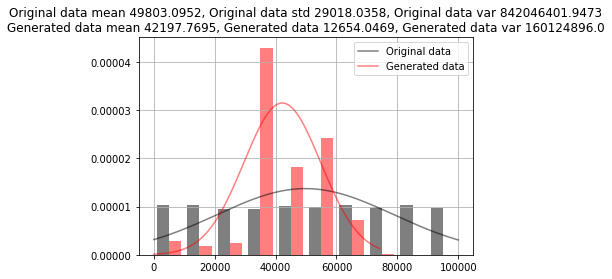

Height Normal distribution


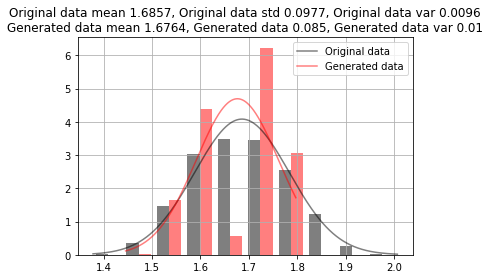

Weight Normal distribution


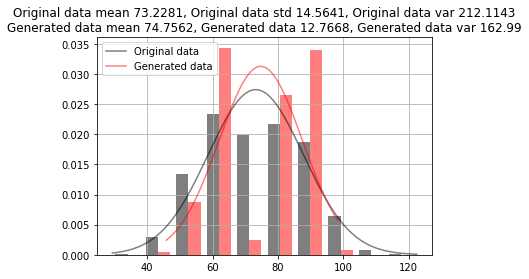

bmi Normal distribution


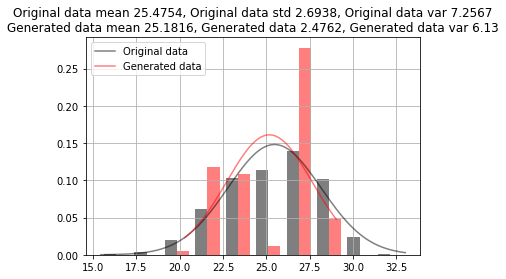

In [279]:
for column in numerical_data.columns:
    print(column, "Normal distribution")
    normal_distribution(og_data[column], bmi_data[column])

Original data


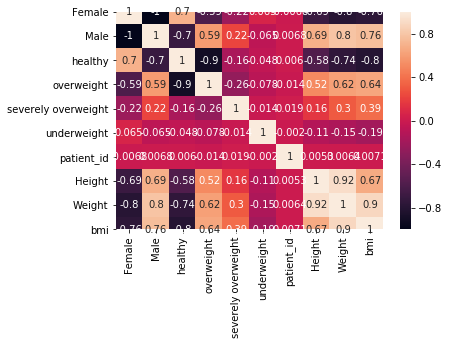

In [281]:
print("Original data")
sns.heatmap(og_data.corr(), annot = True)

Generated data


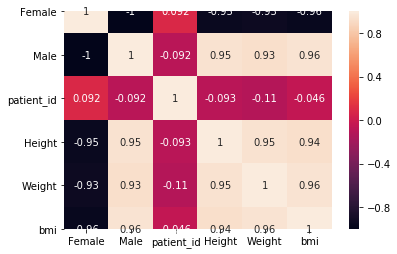

In [282]:
print("Generated data")
sns.heatmap(bmi_data.corr(), annot = True)